<a href="https://colab.research.google.com/github/s-razavi/Time-series-for-price-action-prediction/blob/master/Money_again.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import files/libraries

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import pandas_datareader as pdr
import io
import os
from scipy.stats import pearsonr
import itertools
import random
from random import sample 
import time
import pickle

import xgboost 
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

#TF and Keras for neural net:
import tensorflow as tf
import keras
from keras.datasets import imdb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.models import model_from_json

# !pip install shap
# #!pip install git+https://github.com/slundberg/shap.git
# import shap

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [49]:
# upload the file into google colab
from google.colab import files
uploaded = files.upload()

Saving vxx.csv to vxx (1).csv


# Functions


In [42]:
def pct(df): # make the list differenced by pct, return the same lenght.
  lst = [0]
  for i in range(1,len(df)):
    lst.append(df[i]/df[i-1]-1)
  return lst

def stdev(df, days): # returns the stdev of past 'days' days including today.
  lst = (days-1)*[0]
  for i in range(days,len(df)+1):
    lst.append(np.std(df[i-days:i]))
  return lst

def HV(df, days): # returns the HV of past 'days' days including today.
  lst = (days-1)*[0]
  for i in range(days,len(df)+1):
    lst.append(round(100*np.std(df[i-days:i])*252**0.5,1))
  return lst

def HV_modified(df, days): # returns the HV of past 'days' days including today + days are watered down.
  lst = (days-1)*[0]
  df = [x if x<0 else x/4 for x in df]
  for i in range(days,len(df)+1):
    lst.append(round(100*np.std(df[i-days:i])*252**0.5,1))
  return lst

def pct_fwd(df, days, value = 0): # returns the gain/loss of 'days' days forward refereneced to today.
  lst = []
  for i in range(len(df)-days):
    lst.append(df[i+days-1]/df[i] - 1)
  for j in range(days):
    lst.append(value)
  return lst

def ema(df, EMA_days):# returns the ema of past 'sma_days' days including today.
    sma = np.mean(df[0:EMA_days])
    EMA_list = [0] * (EMA_days - 1)
    EMA_list.append(sma)
    c = 2/(1+EMA_days)
    for i in range(EMA_days,len(df)):
        a = EMA_list[i-1]*(1-c)+ c*df[i]
        EMA_list.append(a)
    return(EMA_list)

def sma(df, sma_days):# returns the sma of past 'sma_days' days including today.
    sma_list = [0] * (sma_days - 1)
    for i in range(sma_days, len(df)+1):
        sma_list.append(np.mean(df[i-sma_days:i]))
    return(sma_list)

# returns two lists of resistance (max) and support (min) over past 'days' days including today
def sup_res(df, days): 
  maxs = [0]*(days - 1)
  mins = [0]*(days - 1)
  for i in range(days, len(df)+1): # len(df)+1 because range does not count the last int.
    mx = max(df[i-days:i])
    mn = min(df[i-days:i])
    maxs.append(mx)
    mins.append(mn)
  return maxs, mins #resistance and support

def slopes(df, days): #returns the slope of past 'days' days including today.
  slopelist = (days-1)*[0]
  for i in range(days,len(df)+1):
    slopelist.append(np.polyfit(np.asarray((range(0,days))),np.asarray(df[i-days:i]),1)[0])
  return slopelist

def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)
    plt.show()
        
#fix random effect
def fix_rnd_Keras():
    seed_value= 0
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.random.set_seed(seed_value)
    from keras import backend as K
    session_conf =  tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

# returns a 3D version of x (number of samples, time steps (window), features) and 2D version of y for LSTM.
# gap defines the overlap between samples, gap = 1: max overlap, gap = window: no overlap
def windower(x,y, window, gap): 
  i = 0
  data_X, data_Y = [], []
  x = np.asarray(x)
  while i in range(len(x) - window):
      data_X.append(x[i:(i + window), :])
      data_Y.append(y[i + window-1])
      i += gap
  return np.asarray(data_X), np.reshape(data_Y,(-1,1))

# return the split of test and train for LSTM: requires lenght to be divisible to batch_size for stateful LSTM
def test_train_split(x, y, batch_size, train_ratio):       
    train_length = int(len(x)*train_ratio)
    for i in range(train_length, train_length+batch_size):
        remainder = i%batch_size
        if remainder == 0:
            train_length = i
            break
    x_train = x[:train_length,:]
    y_train = y[:train_length]

    for i in range(len(x)-batch_size, len(x)):
        remainder = i%batch_size
        if remainder == 0:
            train_length_test = i
            break
    x_test = x[train_length:train_length_test,:]
    y_test = y[train_length:train_length_test]
    return x_train, y_train, x_test, y_test

# One hot encoding of categorical features. 
def OHE(df):
    x = np.asarray(df)
    encoded_x = None
    for i in range(0, x.shape[1]):
      label_encoder = LabelEncoder()
      feature = label_encoder.fit_transform(x[:,i])
      feature = feature.reshape(x.shape[0], 1)
      onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
      feature = onehot_encoder.fit_transform(feature)
      if encoded_x is None:
          encoded_x = feature
      else:
              encoded_x = np.concatenate((encoded_x, feature), axis=1)
    return encoded_x

# VXX

In [102]:
vxx = pd.read_csv(io.BytesIO(uploaded['vxx.csv']))
vxx.columns = ['date', '1st', '2nd', 'n_1st', 'n_2nd', 'n_t', 'weighted', 'cont', 'vix', 'remove', 'vxx']
vxx.drop(['1st', '2nd', 'n_1st', 'n_2nd', 'n_t', 'remove'], axis = 1, inplace=True)
vxx['fwd_10'] = pct_fwd(vxx.vxx, 10)
vxx['fwd_20'] = pct_fwd(vxx.vxx, 20)
vxx['fwd_40'] = pct_fwd(vxx.vxx, 40)
vxx['fwd_20_vix'] = pct_fwd(vxx.vix, 20)
vxx.cont = vxx.weighted/vxx.vix-1

vxx.head()

date  weighted  ...    fwd_40  fwd_20_vix
0     Friday, March 26, 2004     20.32  ... -0.139036   -0.191575
1     Monday, March 29, 2004     19.80  ... -0.136509   -0.104848
2    Tuesday, March 30, 2004     19.64  ... -0.186016   -0.074324
3  Wednesday, March 31, 2004     19.77  ... -0.186064   -0.026882
4   Thursday, April 01, 2004     19.62  ... -0.190544   -0.003003

[5 rows x 9 columns]

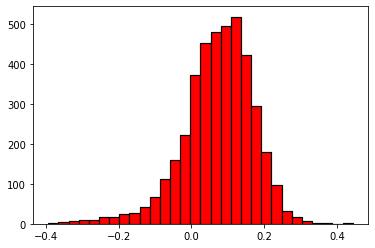

In [27]:
plt.hist(vxx.cont, 30,edgecolor='black', linewidth=1.2, color= 'red');

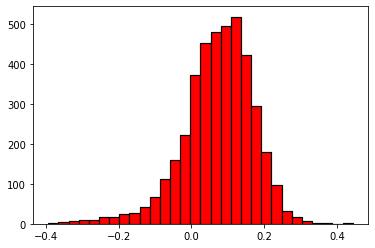

In [61]:
plt.hist(vxx.cont, 30,edgecolor='black', linewidth=1.2, color= 'red');

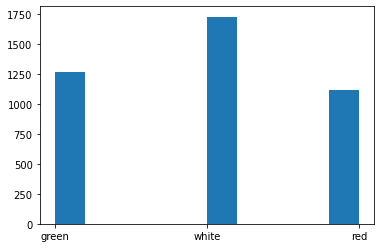

In [103]:
target = vxx['fwd_20_vix']
labels = []
label = []
thresh = 0.1
for i in range(len(target)):
  if target[i] > thresh:
    labels.append('red')
    label.append(0)
  elif target[i] > -thresh and target[i]< thresh:
    labels.append('white')
    label.append(1)
  else:
    labels.append('green')
    label.append(2)
plt.hist(labels);

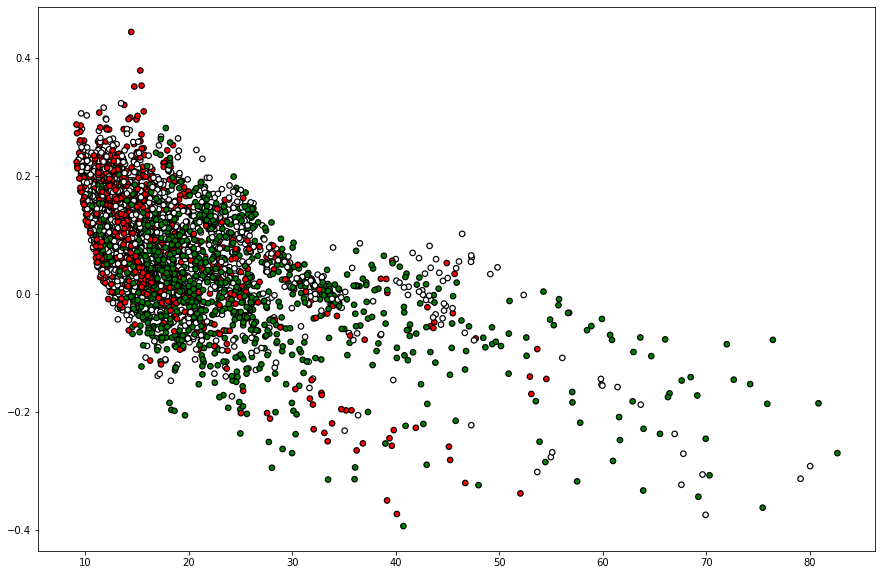

In [104]:
plt.figure(figsize=(15,10))
#plt.axis([9, 30, -0.2, 0.4])
#pyplot.xscale('log')
plt.scatter(vxx.vix, vxx.cont, marker = 'o',edgecolor='black', linewidth=1.2, color = labels, s = 30);

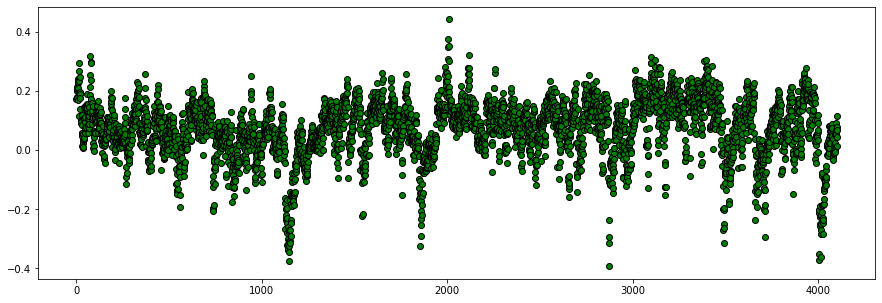

In [31]:
plt.figure(figsize=(15,5))
plt.plot(vxx.cont, linestyle = '', marker  = 'o', color = 'green', mec='black')

# Deploy vix

### Load and feature eng

In [ ]:
vix = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv')
vix.columns = ['Date' ,	'VIX Open' ,	'VIX High' ,	'VIX Low' ,	'VIX Close']
vix = vix.drop([0])

spy = pdr.get_data_yahoo('SPY', start= '2004-01-02', end = '2020-08-07')
print(len(vix),len(spy))

spy['vix'] = [float(x) for x in vix['VIX Close']]
spy['vix_O'] = [float(x) for x in vix['VIX Open']]
spy['vix_H'] = [float(x) for x in vix['VIX High']]
spy['vix_L'] = [float(x) for x in vix['VIX Low']]
spy['pct'] = pct(list(spy['Close']))

spy.drop('Adj Close', axis = 1, inplace = True)
spy['std_5'] = stdev(pct(list(spy['Close'])),5)
spy  = spy.round(3)
print(len(spy))
print(spy.head(2))

# spy close/high/low EMA, SMA
spy['o_c'] = spy['Close']/spy['Open']-1
spy['h_l'] = spy['High']/spy['Low']-1
spy['vol_sma_10'] = sma(spy.Volume, 10)
spy['vol_ema_10'] = ema(spy.Volume, 10)
spy['vol_sma_20'] = sma(spy.Volume, 20)
spy['vol_sma_ema'] = spy['vol_ema_10']/spy['vol_sma_10']-1
spy['vol_sma_ema_20'] = spy['vol_ema_10']/spy['vol_sma_20']-1
spy['vol_spot_ema'] = spy['Volume']/spy['vol_ema_10']-1
spy['sma_10'] = sma(spy.Close, 10)
spy['sma_20'] = sma(spy.Close, 20)
spy['sma_50'] = sma(spy.Close, 50)
spy['sma_100'] = sma(spy.Close, 100)
spy['sma_200'] = sma(spy.Close, 200)
spy['ema_10'] = ema(spy.Close, 10)
spy['spot_sma_10'] = spy['Close']/spy['sma_10'] - 1
spy['sma_10_20'] = spy['sma_10']/spy['sma_20'] - 1
spy['sma_10_50'] = spy['sma_10']/spy['sma_50'] - 1
spy['spot_ema_10'] = spy['Close']/spy['ema_10'] - 1
spy['ema_sma_10'] = spy['ema_10']/spy['sma_10'] - 1
spy['ema_sma_20'] = spy['ema_10']/spy['sma_20'] - 1
spy['ema_sma_50'] = spy['ema_10']/spy['sma_50'] - 1
spy['ema_sma_100'] = spy['ema_10']/spy['sma_100'] - 1
spy['ema_sma_200'] = spy['ema_10']/spy['sma_200'] - 1
spy['res_10'], spy['sup_10'] = sup_res(spy['Close'], 10)
spy['res_20'], spy['sup_20'] = sup_res(spy['Close'], 20)
spy['res_50'], spy['sup_50'] = sup_res(spy['Close'], 50)
spy['res_100'], spy['sup_100'] = sup_res(spy['Close'], 100)
spy['res_200'], spy['sup_200'] = sup_res(spy['Close'], 200)
spy['res10'] = spy.Close/spy['res_10']-1
spy['res20'] = spy.Close/spy['res_20']-1
spy['res50'] = spy.Close/spy['res_50']-1
spy['res100'] = spy.Close/spy['res_100']-1
spy['res200'] = spy.Close/spy['res_200']-1
spy['sup10'] = spy.Close/spy['sup_10']-1
spy['sup20'] = spy.Close/spy['sup_20']-1
spy['sup50'] = spy.Close/spy['sup_50']-1
spy['sup100'] = spy.Close/spy['sup_100']-1
spy['sup200'] = spy.Close/spy['sup_200']-1
spy['slope_5'] = slopes(spy.Close,5)
spy['slope_10'] = slopes(spy.Close,10)
spy['slope_20'] = slopes(spy.Close,20)
spy['slope_100'] = slopes(spy.Close,100)

# vix
spy['vix_ema_10'] = ema(spy.vix, 10)
spy['vix_sma_10'] = sma(spy.vix, 10)
spy['vix_sma_20'] = sma(spy.vix, 20)
spy['vix_res_10'], spy['vix_sup_10'] = sup_res(spy['vix'], 10)
spy['vix_res_20'], spy['vix_sup_20'] = sup_res(spy['vix'], 20)
spy['vix_res_50'], spy['vix_sup_50'] = sup_res(spy['vix'], 50)
spy['vix_res_100'], spy['vix_sup_100'] = sup_res(spy['vix'], 100)
spy['vix_res_200'], spy['vix_sup_200'] = sup_res(spy['vix'], 200)
spy['vix_ema'] =  spy['vix']/spy['vix_ema_10'] - 1
spy['vix_ema_sma_10'] = spy['vix_ema_10']/ spy['vix_sma_10'] - 1
spy['vix_ema_sma_20'] = spy['vix_ema_10']/ spy['vix_sma_20'] - 1
spy['vix_res10'] = spy.vix/spy['vix_res_10']-1
spy['vix_res20'] = spy.vix/spy['vix_res_20']-1
spy['vix_res50'] = spy.vix/spy['vix_res_50']-1
spy['vix_sup10'] = spy.vix/spy['vix_sup_10']-1
spy['vix_sup20'] = spy.vix/spy['vix_sup_20']-1
spy['vix_sup50'] = spy.vix/spy['vix_sup_50']-1
spy['vix_slope_5'] = slopes(spy.vix,5)
spy['vix_slope_10'] = slopes(spy.vix,10)
spy['vix_slope_20'] = slopes(spy.vix,20)
spy['vix_o_c'] = spy['vix']/spy['vix_O']-1
spy['vix_h_l'] = spy['vix_H']/spy['vix_L']-1

spy = spy.replace([np.inf, -np.inf], np.nan)
spy = spy.dropna()
print(len(spy))
spy.head(3)

4179 4179
4179
              High     Low    Open   Close  ...  vix_H  vix_L    pct  std_5
Date                                        ...                            
2004-01-02  112.19  110.73  111.74  111.23  ...  18.68  17.54  0.000    0.0
2004-01-05  112.52  111.59  111.69  112.44  ...  18.49  17.44  0.011    0.0

[2 rows x 11 columns]
3980


High     Low    Open  ...  vix_slope_20   vix_o_c   vix_h_l
Date                                ...                                  
2004-10-18  111.90  110.70  110.89  ...      0.073519 -0.089728  0.103825
2004-10-19  112.23  110.59  112.02  ...      0.074098 -0.072917  0.139665
2004-10-20  110.82  109.75  110.38  ...      0.085519 -0.039457  0.049324

[3 rows x 85 columns]

In [ ]:
col_spy = [ 'vol_sma_ema', 'vol_sma_ema_20', 'ema_sma_100', 'ema_sma_200',
        'spot_sma_10', 'sma_10_20', 'sma_10_50', 'spot_ema_10', 'ema_sma_10', 'ema_sma_20', 'ema_sma_50',
        'res10' ,	'res20' ,	'res50' ,	'sup10' ,	'sup20' ,	'sup50' ,	'slope_20',
        'slope_100', 'sup100', 'sup200', 'res100', 'res200', 'o_c', 'h_l','vol_spot_ema' ,	'slope_5' ,	'slope_10']
         
col_vix = ['vix', 'vix_ema_sma_10', 'vix_ema_sma_20', 'vix_res10', 'vix_res20',
           'vix_res50', 'vix_sup10','vix_slope_20', 'vix_sup20','vix_sup50', 'vix_slope_5',	'vix_slope_10',	
           'vix_o_c', 'vix_h_l', 'vix_ema']

col_vix_spy = col_spy+col_vix
inputs = spy[col_vix_spy]

### Predict

In [ ]:
x = np.asarray(inputs) 
scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
x = scaler.fit_transform(x)
x = np.concatenate((model_nn.predict(x), model_rf.predict_proba(x), model_xgb.predict_proba(x)), axis=1)
preds = [np.argmax(x) for x in model.predict(x)]
df = spy[['Close', 'vix']].copy(deep = True)
df['actual'] = pct_fwd(df.vix, 20, value = 'nan')
df['prediction'] = preds
df['prediction'] = df['prediction'].replace({0: 'long', 1: 'cash', 2: 'short'})
df[-60:]

Close    vix     actual prediction
Date                                           
2020-05-14  284.97  32.61   0.250843       cash
2020-05-15  286.28  31.89   0.131703       cash
2020-05-18  295.00  29.30   0.174061       cash
2020-05-19  291.97  30.53    0.10285       cash
2020-05-20  296.93  27.99   0.195784       long
2020-05-21  294.88  29.53   0.115476       cash
2020-05-22  295.44  28.16   0.247159       cash
2020-05-26  299.08  28.01   0.134238       long
2020-05-27  303.53  27.62   0.135771       long
2020-05-28  302.97  28.59   0.183631       cash
2020-05-29  304.32  27.51    0.17121       cash
2020-06-01  305.55  28.23   0.230252       long
2020-06-02  308.08  26.84   0.184054       long
2020-06-03  312.18  25.66   0.185892       long
2020-06-04  311.36  25.81   0.108873       long
2020-06-05  319.34  24.52   0.128874       long
2020-06-08  323.20  25.81  0.0825262       cash
2020-06-09  320.79  27.57  0.0674646       cash
2020-06-10  319.00  27.57  0.0184984       cash
2020-06-11  300.61  40.79  -0.282667      short
2020-06-12  304.21  36.09  -0.243835      short
2020-06-15  307.05  34.40 -0.0642442      short
2020-06-16  312.96  33.67  -0.123255      short
2020-06-17  311.66  33.47  -0.170601      short
2020-06-18  311.78  32.94   -0.14997      short
2020-06-19  308.64  35.12  -0.268793      short
2020-06-22  310.62  31.77  -0.230091      short
2020-06-23  312.05  31.37  -0.208161      short
2020-06-24  304.09  33.84  -0.281324      short
2020-06-25  307.35  32.22  -0.190565      short
2020-06-26  300.05  34.73  -0.255975      short
2020-06-29  304.46  31.78  -0.221523      short
2020-06-30  308.36  30.43  -0.163983      short
2020-07-01  310.52  28.62  -0.157932      short
2020-07-02  312.23  27.68  -0.105491      short
2020-07-06  317.05  27.94  -0.124553      short
2020-07-07  313.78  29.43  -0.174992      short
2020-07-08  316.18  28.08  -0.153846      short
2020-07-09  314.38  29.26  -0.214286      short
2020-07-10  317.59  27.29  -0.170026      short
2020-07-13  314.84  32.19        nan      short
2020-07-14  318.92  29.52        nan      short
2020-07-15  321.85  27.76        nan       cash
2020-07-16  320.79  28.00        nan       cash
2020-07-17  321.72  25.68        nan       cash
2020-07-20  324.32  24.46        nan       cash
2020-07-21  325.01  24.84        nan       cash
2020-07-22  326.86  24.32        nan       cash
2020-07-23  322.96  26.08        nan       cash
2020-07-24  320.88  25.84        nan       cash
2020-07-27  323.22  24.74        nan       cash
2020-07-28  321.17  25.44        nan       cash
2020-07-29  325.12  24.10        nan       cash
2020-07-30  323.96  24.76        nan       cash
2020-07-31  326.52  24.46        nan       cash
2020-08-03  328.79  24.28        nan       cash
2020-08-04  330.06  23.76        nan       cash
2020-08-05  332.11  22.99        nan       cash
2020-08-06  334.33  22.65        nan       cash
2020-08-07  334.57  22.21        nan       cash

# Model vix

## Import Data

In [ ]:
spy = pdr.get_data_yahoo('SPY', start= '2004-01-02', end = '2020-07-17')
#gld = pdr.get_data_yahoo('gld', start= '2004-11-18', end = '2020-07-17')
#tlt = pdr.get_data_yahoo('TLT', start= '2004-11-18', end = '2020-07-17')
vix = pd.read_csv(io.BytesIO(uploaded['vixcurrent.csv']))
#vix = vix[222:]
print(len(vix),len(spy))

spy['vix'] = list(vix['VIX Close'])
#spy['gld'] = list(gld['Close'])
# spy['tlt'] = list(tlt['Close'])
# spy['gldV'] = list(gld['Volume'])
# spy['tltV'] = list(tlt['Volume'])
spy['vix_O'] = list(vix['VIX Open'])
spy['vix_H'] = list(vix['VIX High'])
spy['vix_L'] = list(vix['VIX Low'])

spy['pct'] = pct(list(spy['Close']))
# spy['hv'] = HV(spy.pct, 10)
# spy['hv_m'] = HV_modified(spy.pct, 10)

spy = spy[:3400]
# # gld = gld[:3400]
# # tlt = tlt[:3400]
vix = vix[:3400] # 3380 left

spy.drop('Adj Close', axis = 1, inplace = True)
spy['std_5'] = stdev(pct(list(spy['Close'])),5)
fwd = 20
spy['fwd_20_vix'] = pct_fwd(list(spy['vix']), fwd)
spy['fwd_20_spy'] = pct_fwd(list(spy['Close']), fwd)
# spy['fwd_20_gld'] = pct_fwd(list(spy['gld']), fwd)
# spy['fwd_20_tlt'] = pct_fwd(list(spy['tlt']), fwd)

spy = spy[:-fwd]
spy  = spy.round(3)
print(len(spy))
spy.head(2)

4164 4164
3380


High     Low    Open  ...  std_5  fwd_20_vix  fwd_20_spy
Date                                ...                               
2004-01-02  112.19  110.73  111.74  ...    0.0      -0.087       0.020
2004-01-05  112.52  111.59  111.69  ...    0.0      -0.022       0.014

[2 rows x 13 columns]

### Historical vol

correlation = 0.88


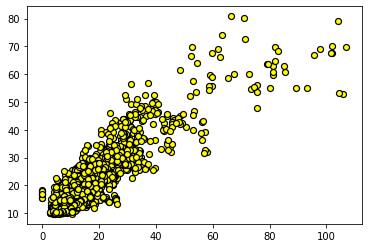

In [ ]:
plt.scatter(spy['hv'], spy['vix'], color = 'yellow',edgecolor='black', linewidth=1.2)
cor, _  = pearsonr(spy['hv'], spy['vix'])
print('correlation = %.2f'% (cor))

correlation = 0.87


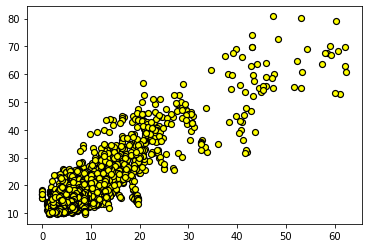

In [ ]:
plt.scatter(spy['hv_m'], spy['vix'], color = 'yellow',edgecolor='black', linewidth=1.2)
cor, _  = pearsonr(spy['hv_m'], spy['vix'])
print('correlation = %.2f'% (cor))

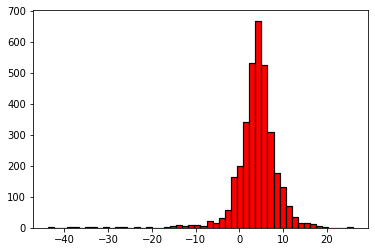

In [ ]:
plt.hist(spy.vix-spy.hv, 50,edgecolor='black', linewidth=1.2, color= 'red');

correlation = 0.18


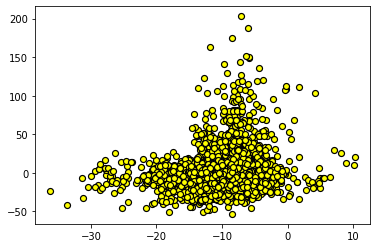

In [ ]:
plt.scatter(spy.hv_m-spy.vix, spy['fwd_20_vix']*100, color = 'yellow',edgecolor='black', linewidth=1.2)
cor, _  = pearsonr(spy.hv_m-spy.vix, spy['fwd_20_vix'])
print('correlation = %.2f'% (cor))

### Stdev in spx with coming change in vix

correlation = -0.02


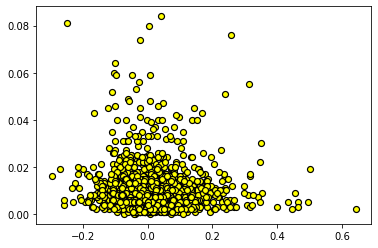

In [ ]:
plt.scatter(spy['fwd_2_vix'], spy['std_5'], color = 'yellow',edgecolor='black', linewidth=1.2)
cor, _  = pearsonr(spy['fwd_2_vix'], spy['std_5'])
print('correlation = %.2f'% (cor))

### Stdev in spx with coming change in spx

correlation = -0.01


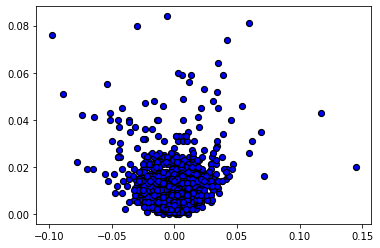

In [ ]:
plt.scatter(spy['fwd_2_spy'], spy['std_5'], color = 'blue',edgecolor='black', linewidth=1.2)
cor, _  = pearsonr(spy['fwd_2_spy'], spy['std_5'])
print('correlation = %.2f'% (cor))

### Stdev in spx with vix

correlation = 0.81


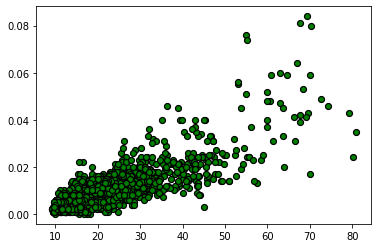

In [ ]:
plt.scatter(spy['vix'], spy['std_5'], color = 'green',edgecolor='black', linewidth=1.2)
cor, _  = pearsonr(spy['vix'], spy['std_5'])
print('correlation = %.2f'% (cor))

## re-test previous work

In [ ]:
spy = pdr.get_data_yahoo('SPY', start= '2000-01-01', end = '2017-10-01')
spy['pct'] = pct(list(spy['Close']))
spy.drop('Adj Close', axis = 1, inplace = True)
spy['fwd_20_spy'] = pct_fwd(list(spy['Close']), 20)
spy  = spy.round(3)
spy.head(2)

High      Low     Open    Close     Volume    pct  fwd_20_spy
Date                                                                        
2000-01-03  148.250  143.875  148.250  145.438  8164300.0  0.000      -0.040
2000-01-04  144.062  139.641  143.531  139.750  8089800.0 -0.039       0.008

In [ ]:
spy['o_c'] = spy['Close']/spy['Open']-1
spy['h_l'] = spy['High']/spy['Low']-1
spy['vol_sma_10'] = spy.Volume/sma(spy.Volume, 10)-1
spy['vol_sma_20'] = spy.Volume/sma(spy.Volume, 20)-1
spy['sma_10'] = sma(spy.Close, 10)
spy['sma_20'] = sma(spy.Close, 20)
spy['sma_50'] = sma(spy.Close, 50)
spy['sma_100'] = sma(spy.Close, 50)
spy['ema_8'] = ema(spy.Close, 8)
spy['spot_sma_20'] = spy['Close']/spy['sma_20'] - 1
spy['spot_sma_50'] = spy['Close']/spy['sma_50'] - 1
spy['spot_sma_100'] = spy['Close']/spy['sma_100'] - 1
spy['sma_20_50'] = spy['sma_20']/spy['sma_50'] - 1
spy['sma_10_100'] = spy['sma_10']/spy['sma_100'] - 1
spy['spot_ema_8'] = spy['Close']/spy['ema_8'] - 1

spy = spy.replace([np.inf, -np.inf], np.nan)
spy = spy.dropna()
spy.head(3)

High      Low     Open  ...  sma_20_50  sma_10_100  spot_ema_8
Date                                   ...                                   
2000-03-14  140.094  136.156  139.281  ...  -0.019918   -0.012060   -0.012344
2000-03-15  140.438  136.062  136.875  ...  -0.019583   -0.010289    0.008298
2000-03-16  146.844  140.875  141.625  ...  -0.017890   -0.005658    0.042569

[3 rows x 22 columns]

In [ ]:
col = ['Volume', 'pct', 'o_c', 'h_l', 'vol_sma_10', 'vol_sma_20',
        'spot_sma_20', 'spot_sma_50','spot_sma_100','sma_10_100', 'sma_20_50',
       'spot_ema_8']

## Creating features

In [ ]:
# spy close/high/low EMA, SMA
spy['o_c'] = spy['Close']/spy['Open']-1
spy['h_l'] = spy['High']/spy['Low']-1
spy['vol_sma_10'] = sma(spy.Volume, 10)
spy['vol_ema_10'] = ema(spy.Volume, 10)
spy['vol_sma_20'] = sma(spy.Volume, 20)
spy['vol_sma_ema'] = spy['vol_ema_10']/spy['vol_sma_10']-1
spy['vol_sma_ema_20'] = spy['vol_ema_10']/spy['vol_sma_20']-1
spy['vol_spot_ema'] = spy['Volume']/spy['vol_ema_10']-1
spy['sma_10'] = sma(spy.Close, 10)
spy['sma_20'] = sma(spy.Close, 20)
spy['sma_50'] = sma(spy.Close, 50)
spy['sma_100'] = sma(spy.Close, 100)
spy['sma_200'] = sma(spy.Close, 200)
spy['ema_10'] = ema(spy.Close, 10)
spy['spot_sma_10'] = spy['Close']/spy['sma_10'] - 1
spy['sma_10_20'] = spy['sma_10']/spy['sma_20'] - 1
spy['sma_10_50'] = spy['sma_10']/spy['sma_50'] - 1
spy['spot_ema_10'] = spy['Close']/spy['ema_10'] - 1
spy['ema_sma_10'] = spy['ema_10']/spy['sma_10'] - 1
spy['ema_sma_20'] = spy['ema_10']/spy['sma_20'] - 1
spy['ema_sma_50'] = spy['ema_10']/spy['sma_50'] - 1
spy['ema_sma_100'] = spy['ema_10']/spy['sma_100'] - 1
spy['ema_sma_200'] = spy['ema_10']/spy['sma_200'] - 1


spy['res_10'], spy['sup_10'] = sup_res(spy['Close'], 10)
spy['res_20'], spy['sup_20'] = sup_res(spy['Close'], 20)
spy['res_50'], spy['sup_50'] = sup_res(spy['Close'], 50)
spy['res_100'], spy['sup_100'] = sup_res(spy['Close'], 100)
spy['res_200'], spy['sup_200'] = sup_res(spy['Close'], 200)
spy['res10'] = spy.Close/spy['res_10']-1
spy['res20'] = spy.Close/spy['res_20']-1
spy['res50'] = spy.Close/spy['res_50']-1
spy['res100'] = spy.Close/spy['res_100']-1
spy['res200'] = spy.Close/spy['res_200']-1
spy['sup10'] = spy.Close/spy['sup_10']-1
spy['sup20'] = spy.Close/spy['sup_20']-1
spy['sup50'] = spy.Close/spy['sup_50']-1
spy['sup100'] = spy.Close/spy['sup_100']-1
spy['sup200'] = spy.Close/spy['sup_200']-1
spy['slope_5'] = slopes(spy.Close,5)
spy['slope_10'] = slopes(spy.Close,10)
spy['slope_20'] = slopes(spy.Close,20)
spy['slope_100'] = slopes(spy.Close,100)

# vix
spy['vix_ema_10'] = ema(spy.vix, 10)
spy['vix_sma_10'] = sma(spy.vix, 10)
spy['vix_sma_20'] = sma(spy.vix, 20)
spy['vix_res_10'], spy['vix_sup_10'] = sup_res(spy['vix'], 10)
spy['vix_res_20'], spy['vix_sup_20'] = sup_res(spy['vix'], 20)
spy['vix_res_50'], spy['vix_sup_50'] = sup_res(spy['vix'], 50)
spy['vix_res_100'], spy['vix_sup_100'] = sup_res(spy['vix'], 100)
spy['vix_res_200'], spy['vix_sup_200'] = sup_res(spy['vix'], 200)
spy['vix_ema'] =  spy['vix']/spy['vix_ema_10'] - 1
spy['vix_ema_sma_10'] = spy['vix_ema_10']/ spy['vix_sma_10'] - 1
spy['vix_ema_sma_20'] = spy['vix_ema_10']/ spy['vix_sma_20'] - 1
spy['vix_res10'] = spy.vix/spy['vix_res_10']-1
spy['vix_res20'] = spy.vix/spy['vix_res_20']-1
spy['vix_res50'] = spy.vix/spy['vix_res_50']-1
spy['vix_sup10'] = spy.vix/spy['vix_sup_10']-1
spy['vix_sup20'] = spy.vix/spy['vix_sup_20']-1
spy['vix_sup50'] = spy.vix/spy['vix_sup_50']-1
spy['vix_slope_5'] = slopes(spy.vix,5)
spy['vix_slope_10'] = slopes(spy.vix,10)
spy['vix_slope_20'] = slopes(spy.vix,20)
spy['vix_o_c'] = spy['vix']/spy['vix_O']-1
spy['vix_h_l'] = spy['vix_H']/spy['vix_L']-1

# gld
# spy['gld_sma_50'] = sma(spy.gld, 50)
# spy['gld_ema_10'] = ema(spy.gld, 10)
# spy['gld_ema_10_50'] = spy['gld_ema_10']/spy['gld_sma_50'] - 1
# spy['gld_spot_ema_10'] = spy['gld']/spy['gld_ema_10'] - 1
# spy['gld_vol_ema_10'] = ema(spy.gldV, 10)
# spy['gld_vol_sma_50'] = sma(spy.gldV, 50)
# spy['gld_vol_sma_ema'] = spy['gld_vol_ema_10']/spy['gld_vol_sma_50']-1
# spy['gld_vol_spot_ema'] = spy['gldV']/spy['gld_vol_ema_10']-1

# # tlt
# spy['tlt_sma_50'] = sma(spy.tlt, 50)
# spy['tlt_ema_10'] = ema(spy.tlt, 10)
# spy['tlt_ema_10_50'] = spy['tlt_ema_10']/spy['tlt_sma_50'] - 1
# spy['tlt_spot_ema_10'] = spy['tlt']/spy['tlt_ema_10'] - 1
# spy['tlt_vol_ema_10'] = ema(spy.tltV, 10)
# spy['tlt_vol_sma_50'] = sma(spy.tltV, 50)
# spy['tlt_vol_sma_ema'] = spy['tlt_vol_ema_10']/spy['tlt_vol_sma_50']-1
# spy['tlt_vol_spot_ema'] = spy['tltV']/spy['tlt_vol_ema_10']-1
# print(len(spy))

spy = spy.replace([np.inf, -np.inf], np.nan)
spy = spy.dropna()
print(len(spy))

spy.head(3) # 3181 for train

3945


High     Low    Open  ...  vix_slope_20   vix_o_c   vix_h_l
Date                                ...                                  
2004-10-18  111.90  110.70  110.89  ...      0.073519 -0.089728  0.103825
2004-10-19  112.23  110.59  112.02  ...      0.074098 -0.072917  0.139665
2004-10-20  110.82  109.75  110.38  ...      0.085519 -0.039457  0.049324

[3 rows x 87 columns]

In [ ]:
col_spy = [ 'vol_sma_ema', 'vol_sma_ema_20', 'ema_sma_100', 'ema_sma_200',
        'spot_sma_10', 'sma_10_20', 'sma_10_50', 'spot_ema_10', 'ema_sma_10', 'ema_sma_20', 'ema_sma_50',
        'res10' ,	'res20' ,	'res50' ,	'sup10' ,	'sup20' ,	'sup50' ,	'slope_20',
        'slope_100', 'sup100', 'sup200', 'res100', 'res200', 'o_c', 'h_l','vol_spot_ema' ,	'slope_5' ,	'slope_10']
         
col_vix = ['vix', 'vix_ema_sma_10', 'vix_ema_sma_20', 'vix_res10', 'vix_res20',
           'vix_res50', 'vix_sup10','vix_slope_20', 'vix_sup20','vix_sup50', 'vix_slope_5',	'vix_slope_10',	
           'vix_o_c', 'vix_h_l', 'vix_ema']

col_gld = ['gld_ema_10_50', 'gld_spot_ema_10', 'gld_vol_sma_ema', 'gld_vol_spot_ema']
col_tlt = ['tlt_ema_10_50', 'tlt_spot_ema_10', 'tlt_vol_sma_ema', 'tlt_vol_spot_ema']

col_tlt_gld = col_gld + col_tlt
               
col_vix_spy = col_spy+col_vix
cols = col_gld + col_vix_spy

To output multiple subplots, the figure containing the passed axes is being cleared


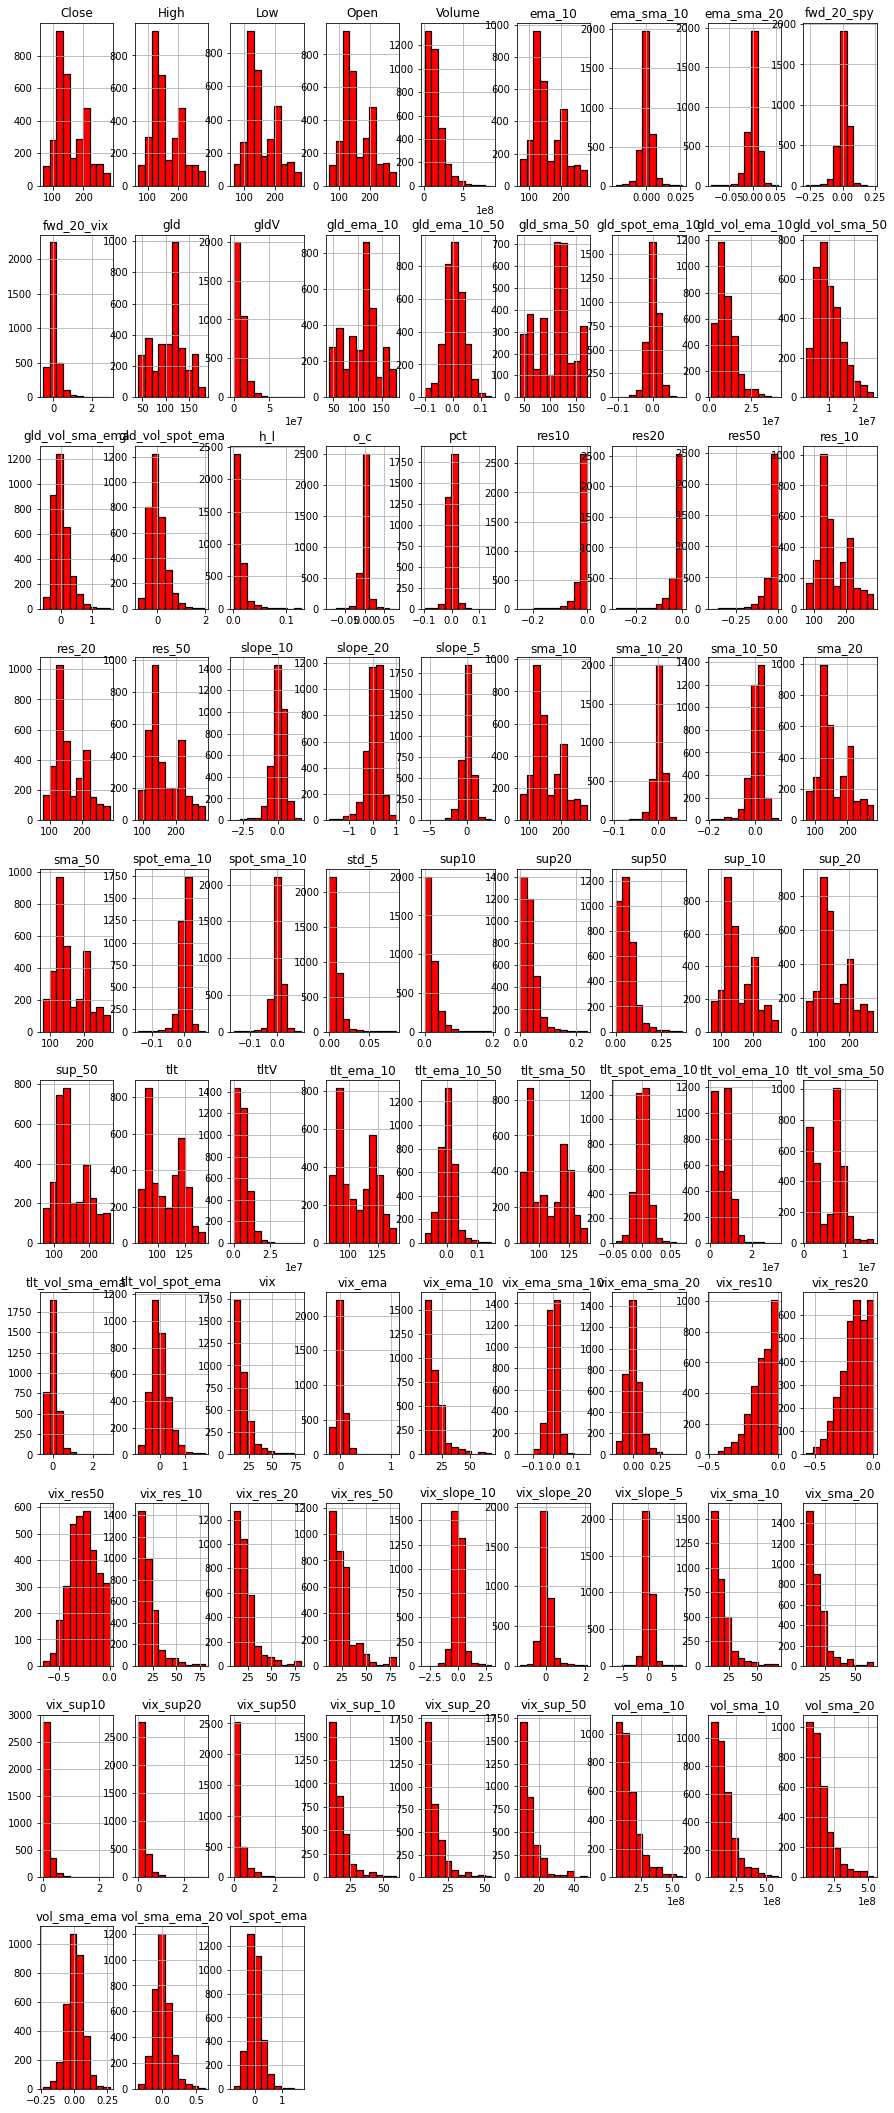

In [ ]:
fig = plt.figure(figsize = (15,38))
ax = fig.gca()
spy.hist(edgecolor='black', linewidth=1.2, color= 'red', ax = ax);

### Labels for ML

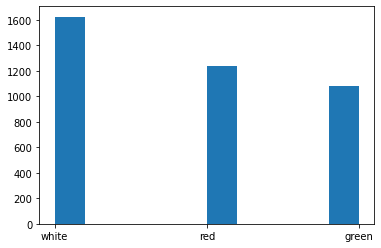

In [ ]:
df = spy[col_vix_spy]
target = spy['fwd_20_vix']
labels = []
label = []
thresh = 0.1
for i in range(len(target)):
  if target[i] > thresh:
    labels.append('green')
    label.append(0)
  elif target[i] > -thresh and target[i]< thresh:
    labels.append('white')
    label.append(1)
  else:
    labels.append('red')
    label.append(2)
plt.hist(labels);

## RF CV

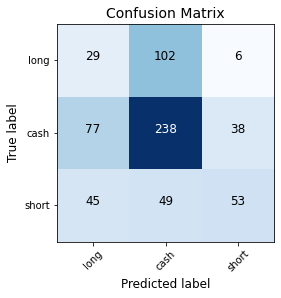

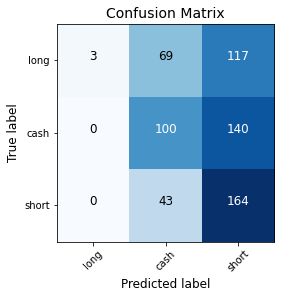

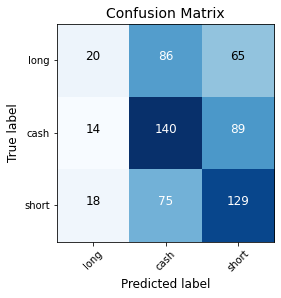

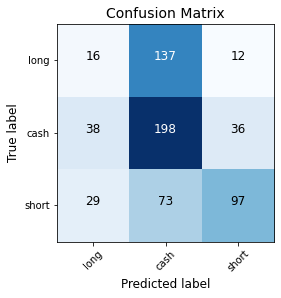

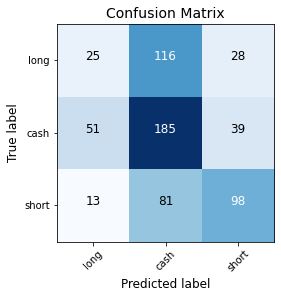

80 20 20 5
long_f1: 0.15 std:  0.06 
 long_p: 0.41 std:  0.3 
 short_p: 0.53 std:  0.1 
 short_f1: 0.52 std:  0.04 



In [ ]:
kf = KFold(n_splits=5)
scaler = MinMaxScaler(feature_range=(0.00001, 1))
x = np.asarray(df) 
x = scaler.fit_transform(x)
y = np.asarray(label)
n_estimators, max_depths, min_samples_split, min_samples_leaf = [80], [20], [20], [5]

for estimators in n_estimators:   
      for max_depth in max_depths:
          for min_sample_split in min_samples_split:
              for min_sample_leaf in min_samples_leaf:
                long_f1,short_p,short_f1,long_p= [],[],[],[]
                for train_index, test_index in kf.split(x):
                  x_train, x_test = x[train_index], x[test_index]
                  y_train, y_test = y[train_index], y[test_index]
                  model_rf = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth,
                    min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, 
                    random_state = 13)#, class_weight = {0:1.0,1:0.6, 2:0.89})
                  model_rf.fit(x_train, y_train)  
                  prediction_train = model_rf.predict(x_train)
                  prediction_test = model_rf.predict(x_test)
                  rpt = classification_report(y_test, prediction_test, target_names = ['long', 'cash', 'short'],
                                              output_dict=True)

                  pretty_print_conf_matrix(y_test,prediction_test, classes= ['long', 'cash', 'short'],
                                        normalize=False, title='Confusion Matrix')

                  long_f1.append(rpt['long']['f1-score'])
                  short_p.append(rpt['short']['precision'])   
                  short_f1.append(rpt['short']['f1-score']) 
                  long_p.append(rpt['long']['precision'])
                print(estimators, max_depth, min_sample_split,min_sample_leaf)
                print('long_f1:', round(np.mean(long_f1),2), 'std: ', round(np.std(long_f1),2), '\n', 
                    'long_p:', round(np.mean(long_p),2), 'std: ', round(np.std(long_p),2), '\n',
                      'short_p:', round(np.mean(short_p),2), 'std: ', round(np.std(short_p), 2), '\n', 
                    'short_f1:', round(np.mean(short_f1),2), 'std: ', round(np.std(short_f1),2), '\n')
                

In [ ]:
rpt

{'accuracy': 0.48427672955974843,
 'cash': {'f1-score': 0.563165905631659,
  'precision': 0.48429319371727747,
  'recall': 0.6727272727272727,
  'support': 275},
 'long': {'f1-score': 0.19379844961240314,
  'precision': 0.2808988764044944,
  'recall': 0.14792899408284024,
  'support': 169},
 'macro avg': {'f1-score': 0.43532798769573305,
  'precision': 0.45304382135372195,
  'recall': 0.44369097782559325,
  'support': 636},
 'short': {'f1-score': 0.5490196078431372,
  'precision': 0.593939393939394,
  'recall': 0.5104166666666666,
  'support': 192},
 'weighted avg': {'f1-score': 0.4607457967595671,
  'precision': 0.4633473302216581,
  'recall': 0.48427672955974843,
  'support': 636}}

### Importance

In [ ]:
feature_importances = pd.DataFrame({'importance':model.feature_importances_, 'feature' :col_vix_spy})
feature_importances = feature_importances.round(3)
feature_importances.columns =['feature', 'importance']
feature_importances = feature_importances.sort_values('feature', ascending = False).reset_index(drop=True)
feature_importances

feature      importance
0     0.059             vix
1     0.055          res200
2     0.050     ema_sma_200
3     0.047           res50
4     0.042          sup200
5     0.040          res100
6     0.037       slope_100
7     0.035     ema_sma_100
8     0.034           sup50
9     0.033       vix_sup20
10    0.032       vix_res50
11    0.031          sup100
12    0.031       vix_sup50
13    0.026      ema_sma_50
14    0.023  vix_ema_sma_20
15    0.022        slope_20
16    0.022    vix_slope_20
17    0.022       sma_10_50
18    0.022      ema_sma_20
19    0.020  vol_sma_ema_20
20    0.020           sup20
21    0.019       vix_res20
22    0.019     vol_sma_ema
23    0.018           res20
24    0.017       sma_10_20
25    0.016     spot_ema_10
26    0.015           res10
27    0.015     spot_sma_10
28    0.014         vix_ema
29    0.014      ema_sma_10
30    0.014           sup10
31    0.014       vix_res10
32    0.013       vix_sup10
33    0.013             h_l
34    0.013    vix_slope_10
35    0.013        slope_10
36    0.012         slope_5
37    0.012  vix_ema_sma_10
38    0.011         vix_h_l
39    0.011     vix_slope_5
40    0.010         vix_o_c
41    0.009    vol_spot_ema
42    0.008             o_c

### SHAP

In [ ]:
explainerRF = shap.TreeExplainer(model_rf,shap.sample(x_train, 100))

In [ ]:
shap_values = explainerRF.shap_values(x_train)#, check_additivity=False)

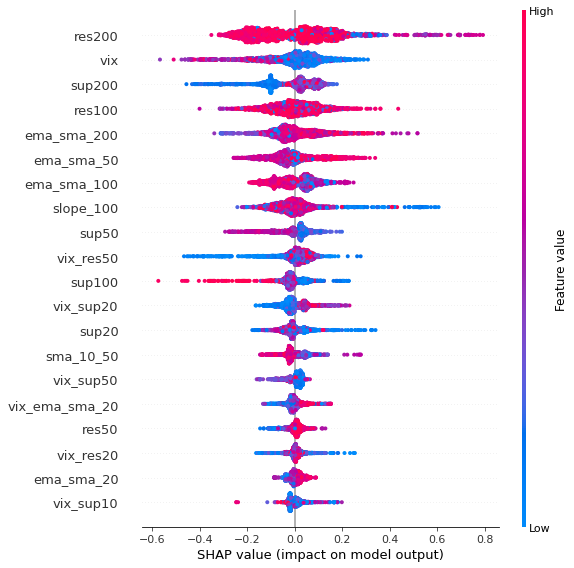

In [ ]:
shap.summary_plot(shap_values[0], x_train, feature_names=col_vix_spy) # volitility increases

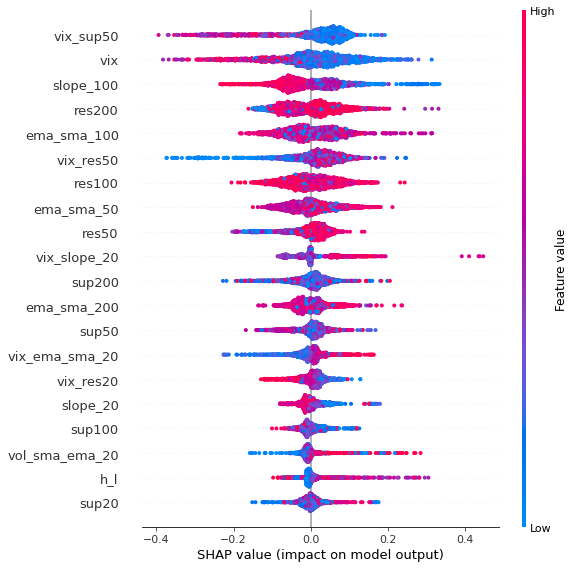

In [ ]:
shap.summary_plot(shap_values[1], x_train, feature_names=col_vix_spy)

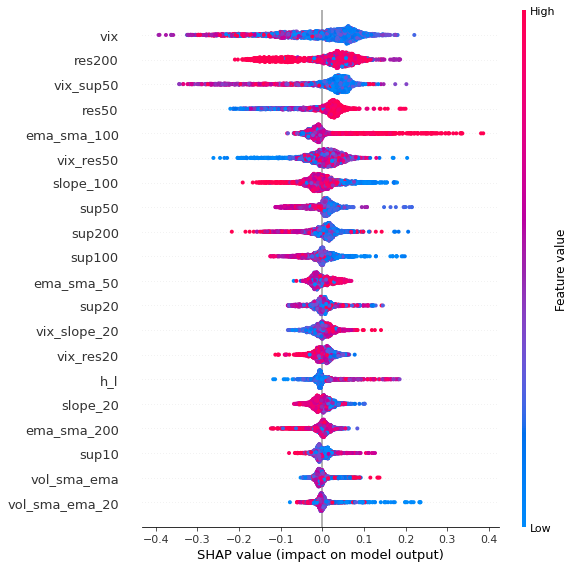

In [ ]:
shap.summary_plot(shap_values[2], x_train, feature_names=col_vix_spy) # class for vol decreases. 

## XGB CV

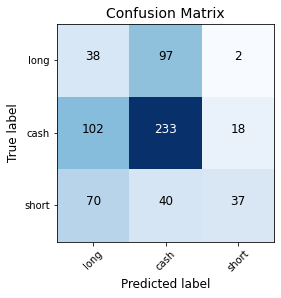

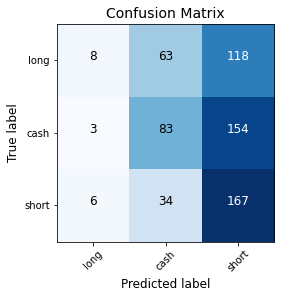

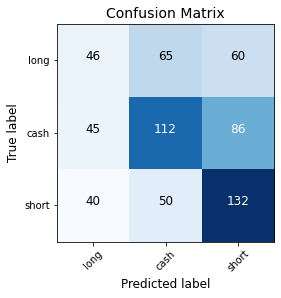

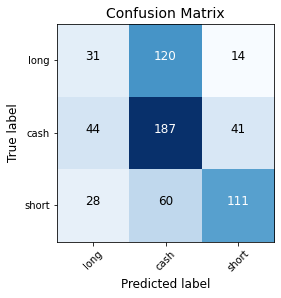

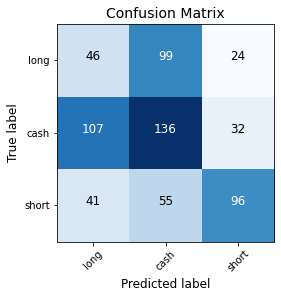

6 0.03 100
long_f1: 0.22 std:  0.08 
 long_p: 0.31 std:  0.1 
 short_p: 0.56 std:  0.11 
 short_f1: 0.51 std:  0.08 



In [ ]:
kf = KFold(n_splits=5)
scaler = MinMaxScaler(feature_range=(0.00001, 1))
x = np.asarray(df) 
x = scaler.fit_transform(x)
y = np.asarray(label)
max_depths, learning_rates, n_estimators, scale_pos_weights  = [6], [0.03], [100], [1]

for n_estimator in n_estimators:   
      for max_depth in max_depths:
          for learning_rate in learning_rates:
            for scale_pos_weight in scale_pos_weights: 
                long_f1,short_p,short_f1,long_p= [],[],[],[]
                for train_index, test_index in kf.split(x):
                  x_train, x_test = x[train_index], x[test_index]
                  y_train, y_test = y[train_index], y[test_index]
                  model_xgb =  XGBClassifier(max_depth=max_depth, learning_rate= learning_rate,
                                        n_estimators=n_estimator, scale_pos_weight = scale_pos_weight )
                  model_xgb.fit(x_train, y_train)#, sample_weight=np.asarray([1,1,1]))  
                  prediction_train = model_xgb.predict(x_train)
                  prediction_test = model_xgb.predict(x_test)
                  rpt = classification_report(y_test, prediction_test, target_names = ['long', 'cash', 'short'],
                                              output_dict=True)

                  pretty_print_conf_matrix(y_test,prediction_test, classes= ['long', 'cash', 'short'],
                                        normalize=False, title='Confusion Matrix')

                  long_f1.append(rpt['long']['f1-score'])
                  short_p.append(rpt['short']['precision'])   
                  short_f1.append(rpt['short']['f1-score']) 
                  long_p.append(rpt['long']['precision'])
                print(max_depth, learning_rate, n_estimator)
                print('long_f1:', round(np.mean(long_f1),2), 'std: ', round(np.std(long_f1),2), '\n', 
                    'long_p:', round(np.mean(long_p),2), 'std: ', round(np.std(long_p),2), '\n',
                      'short_p:', round(np.mean(short_p),2), 'std: ', round(np.std(short_p), 2), '\n', 
                    'short_f1:', round(np.mean(short_f1),2), 'std: ', round(np.std(short_f1),2), '\n')

### Importance

In [ ]:
feature_importances = pd.DataFrame({'importance':model.feature_importances_, 'feature' :col_vix_spy})
feature_importances = feature_importances.round(3)
feature_importances.columns =['feature', 'importance']
feature_importances = feature_importances.sort_values('feature', ascending = False).reset_index(drop=True)
feature_importances

feature      importance
0     0.153          res100
1     0.061          res200
2     0.033          sup100
3     0.031       vix_res50
4     0.031     ema_sma_200
5     0.031             vix
6     0.030       vix_sup20
7     0.028           sup50
8     0.026       slope_100
9     0.025           sup20
10    0.024          sup200
11    0.024      ema_sma_50
12    0.023           res50
13    0.023       vix_res20
14    0.021  vix_ema_sma_20
15    0.021        slope_20
16    0.021       vix_sup50
17    0.021    vix_slope_20
18    0.021       sma_10_50
19    0.020     ema_sma_100
20    0.019           sup10
21    0.019      ema_sma_20
22    0.019       vix_res10
23    0.017       vix_sup10
24    0.017  vol_sma_ema_20
25    0.017      ema_sma_10
26    0.017           res20
27    0.016     vol_sma_ema
28    0.016         slope_5
29    0.015        slope_10
30    0.015     spot_ema_10
31    0.014  vix_ema_sma_10
32    0.014     spot_sma_10
33    0.014       sma_10_20
34    0.013         vix_ema
35    0.013           res10
36    0.012    vix_slope_10
37    0.012     vix_slope_5
38    0.012         vix_h_l
39    0.012             h_l
40    0.011         vix_o_c
41    0.009             o_c
42    0.008    vol_spot_ema

### SHAP

In [ ]:
explainerRF = shap.TreeExplainer(model_xgb,shap.sample(x_train, 100))

In [ ]:
shap_values = explainerRF.shap_values(x_train)#, check_additivity=False)

100%|===================| 7620/7635 [01:52<00:00]       

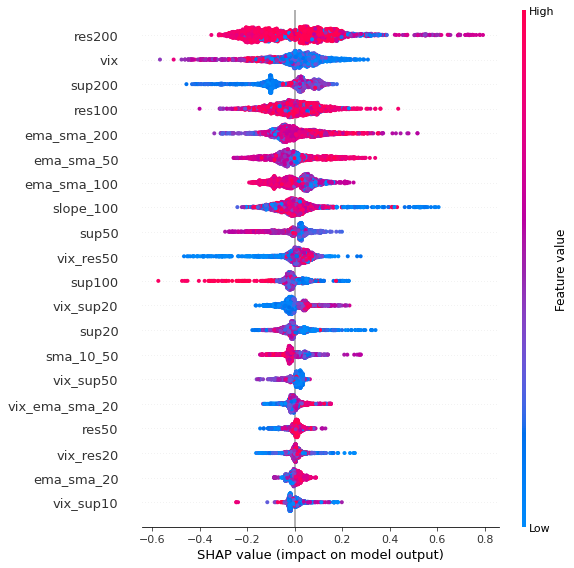

In [ ]:
shap.summary_plot(shap_values[0], x_train, feature_names=col_vix_spy) # volitility increases

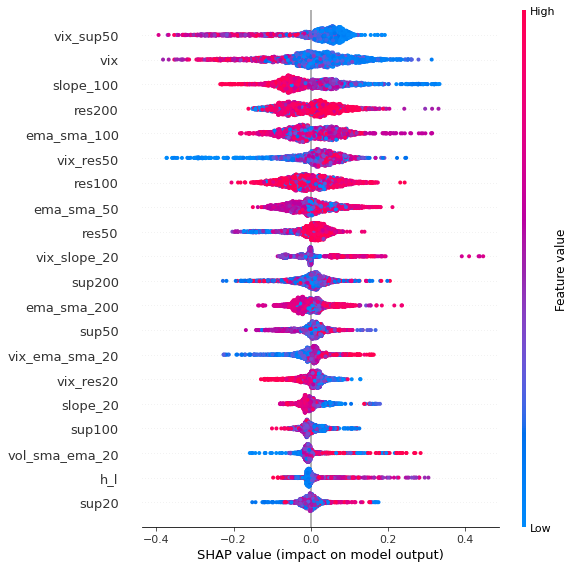

In [ ]:
shap.summary_plot(shap_values[1], x_train, feature_names=col_vix_spy) # volitility increases

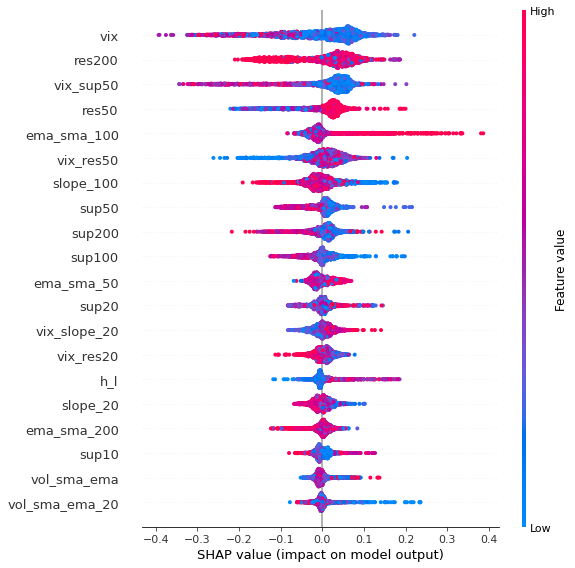

In [ ]:
shap.summary_plot(shap_values[2], x_train, feature_names=col_vix_spy)

## NN CV

In [ ]:
kf = KFold(n_splits=5)
t = time.time()
x = np.asarray(df)
scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
x = scaler.fit_transform(x)
y = np.asarray(label)


softmax_units = len(np.unique(labels))
#for loops were used to get to these optimal values for units, lr, epochs, etc:
units = [50]
epochs = 50
batch_sizes = [16]
lrs = [0.001]
fix_rnd_Keras() # fixing rnd of calculations

for lr in lrs:
    for unit in units:
        for batch_size in batch_sizes:
          long_f1,short_p,short_f1,long_p= [],[],[],[]
          for train_index, test_index in kf.split(x):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model_nn = Sequential()
            model_nn.add(Dense(units = unit,input_dim = x_train.shape[1], activation='relu'))
            model_nn.add(Dropout(0.5))
            
            model_nn.add(Dense(units = softmax_units,  activation='softmax'))
            opt = SGD(lr=lr, momentum=0.9, decay=0.001)
            opt = Adam(lr = lr)
            model_nn.compile(optimizer = opt, loss='sparse_categorical_crossentropy' ,  metrics=['accuracy'])
            history = model_nn.fit(x_train, y_train, epochs = epochs, batch_size = batch_size,
          validation_data=(x_test, y_test),verbose = 0, shuffle=False, class_weight = {0:1.0,1:0.64, 2:0.89})

            
            pred = model_nn.predict(x_test) 
            preds = []
            for i in range(len(pred)):
                preds.append(np.argmax(pred[i]))
            pretty_print_conf_matrix(y_test,preds, 
                classes= ['long', 'cash', 'short'],normalize=False, title='Confusion Matrix')
            rpt = classification_report(y_test, preds, target_names = ['long', 'cash', 'short'],output_dict=True)
            long_f1.append(rpt['long']['f1-score'])
            short_p.append(rpt['short']['precision'])   
            short_f1.append(rpt['short']['f1-score']) 
            long_p.append(rpt['long']['precision'])
          print('it took: ', round(time.time()-t), lr,unit, batch_size)
          print('long_f1:', round(np.mean(long_f1),2), 'std: ', round(np.std(long_f1),2), '\n', 
                'long_p:', round(np.mean(long_p),2), 'std: ', round(np.std(long_p),2), '\n',
                  'short_p:', round(np.mean(short_p),2), 'std: ', round(np.std(short_p), 2), '\n', 
                'short_f1:', round(np.mean(short_f1),2), 'std: ', round(np.std(short_f1),2), '\n')
          
          pyplot.plot(history.history['loss'], label='train')
          pyplot.plot(history.history['val_loss'], label='test')
          pyplot.legend()
          pyplot.show()

### Probabilities and predictions

In [ ]:
pred = model_nn.predict(x) 
preds = []
for i in range(len(pred)):
    preds.append(np.argmax(pred[i]))
predictions = pd.DataFrame(pred, columns=['long', 'cash', 'short'])
predictions['predicted'] = preds
predictions['y'] = label
predictions[1900:1960]

long      cash     short  predicted  y
1900  0.292235  0.326139  0.381627          2  0
1901  0.196837  0.255243  0.547920          2  0
1902  0.198165  0.275007  0.526829          2  0
1903  0.182587  0.252189  0.565225          2  0
1904  0.157699  0.234173  0.608128          2  0
1905  0.186683  0.260987  0.552330          2  0
1906  0.157432  0.233104  0.609464          2  1
1907  0.134963  0.209193  0.655844          2  1
1908  0.137070  0.209610  0.653320          2  1
1909  0.136269  0.207012  0.656719          2  1
1910  0.121138  0.192680  0.686182          2  2
1911  0.115858  0.192935  0.691208          2  2
1912  0.177127  0.239406  0.583468          2  2
1913  0.178890  0.230940  0.590170          2  2
1914  0.190072  0.240530  0.569398          2  2
1915  0.213057  0.245328  0.541616          2  1
1916  0.209539  0.242983  0.547478          2  2
1917  0.246420  0.263595  0.489985          2  1
1918  0.170756  0.215488  0.613757          2  2
1919  0.172996  0.218726  0.608278          2  2
1920  0.126951  0.192044  0.681006          2  2
1921  0.127883  0.195430  0.676687          2  2
1922  0.161858  0.219949  0.618193          2  2
1923  0.250164  0.263305  0.486531          2  2
1924  0.256138  0.263576  0.480286          2  2
1925  0.265518  0.271398  0.463084          2  2
1926  0.225512  0.241779  0.532710          2  2
1927  0.262255  0.268067  0.469677          2  2
1928  0.229983  0.242532  0.527485          2  2
1929  0.270717  0.274073  0.455210          2  2
1930  0.273230  0.275630  0.451140          2  2
1931  0.299572  0.297582  0.402846          2  1
1932  0.303519  0.298775  0.397706          2  2
1933  0.340417  0.331912  0.327671          0  1
1934  0.257008  0.268733  0.474259          2  2
1935  0.331834  0.328870  0.339296          2  2
1936  0.251784  0.264114  0.484102          2  1
1937  0.269542  0.278192  0.452266          2  1
1938  0.275207  0.284400  0.440393          2  1
1939  0.271906  0.277285  0.450809          2  2
1940  0.337889  0.329351  0.332760          0  1
1941  0.349396  0.338059  0.312545          0  1
1942  0.350946  0.338352  0.310702          0  0
1943  0.314159  0.308757  0.377084          2  1
1944  0.347205  0.339813  0.312982          0  1
1945  0.310859  0.307437  0.381704          2  2
1946  0.284296  0.285902  0.429802          2  2
1947  0.315492  0.313759  0.370750          2  2
1948  0.284420  0.290910  0.424669          2  2
1949  0.348666  0.342899  0.308435          0  1
1950  0.347677  0.342024  0.310300          0  2
1951  0.347172  0.339011  0.313817          0  2
1952  0.360591  0.348184  0.291225          0  1
1953  0.397968  0.377777  0.224255          0  1
1954  0.376116  0.362761  0.261123          0  2
1955  0.271336  0.275219  0.453445          2  2
1956  0.222357  0.248869  0.528774          2  2
1957  0.227882  0.259939  0.512179          2  2
1958  0.306118  0.304335  0.389548          2  2
1959  0.322003  0.314876  0.363121          2  1

## Ensemble

Tuning hyperparameters for the ensemble trained on each section of data individually.

Among 5 models, 4 are trained on training data that includes the test for the ensemble, thus it gives too good fit as it already seen the data. 

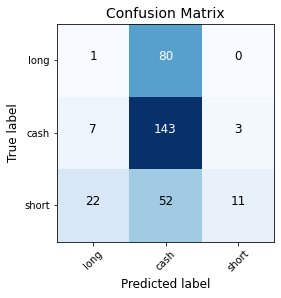

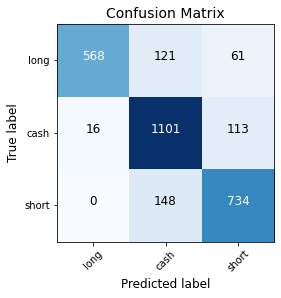

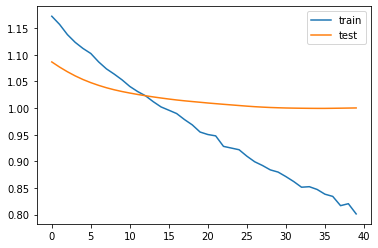

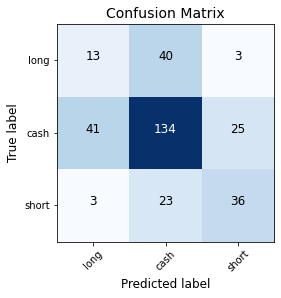

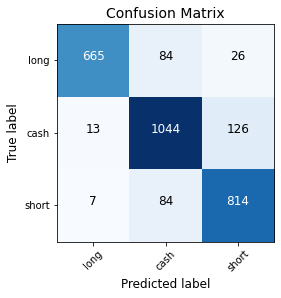

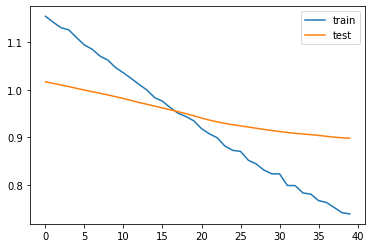

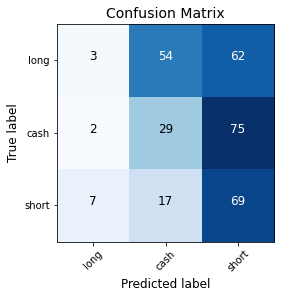

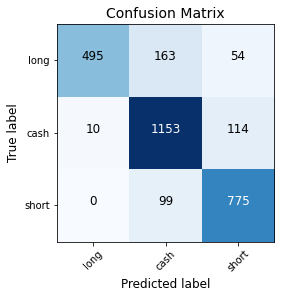

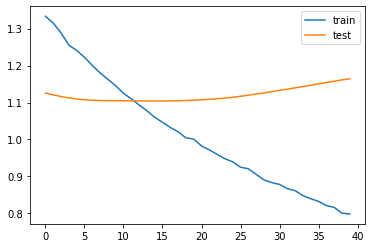

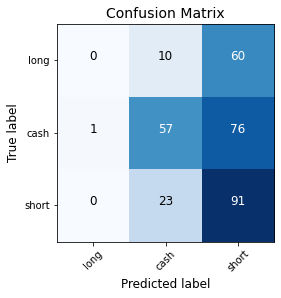

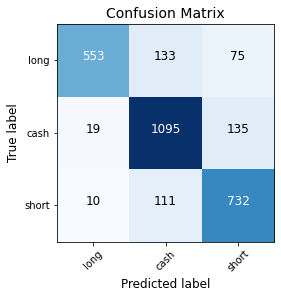

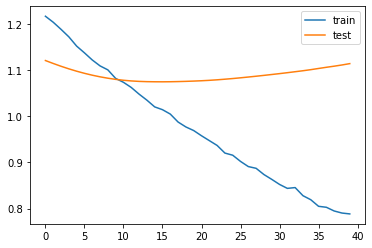

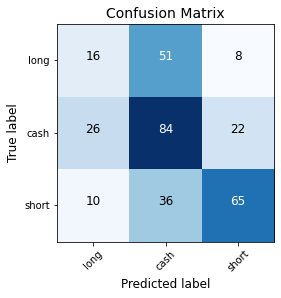

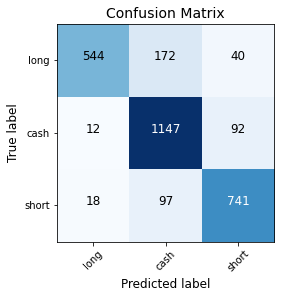

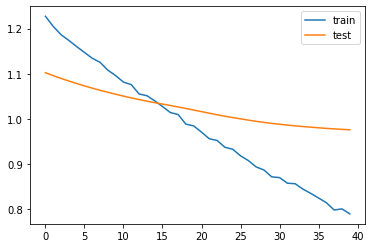

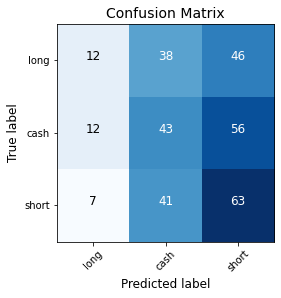

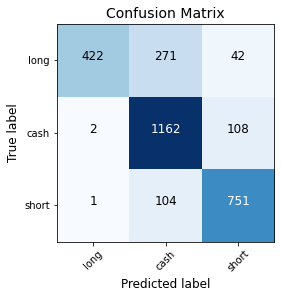

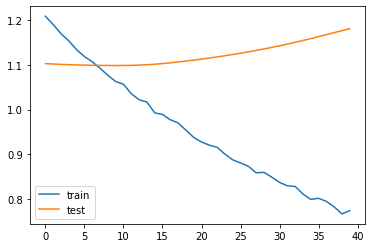

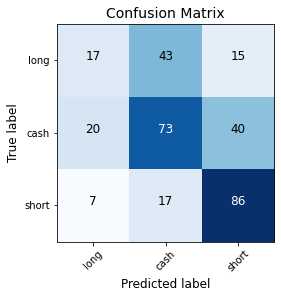

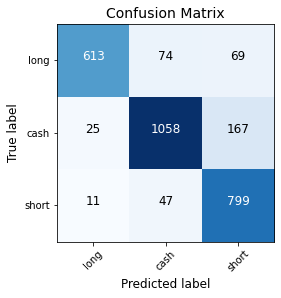

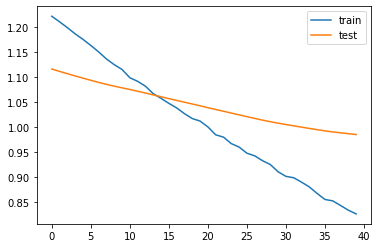

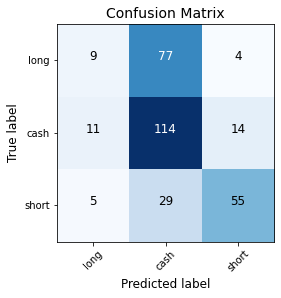

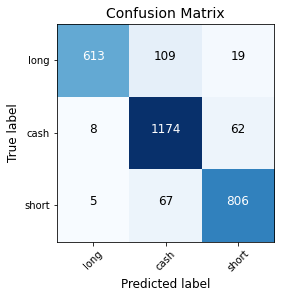

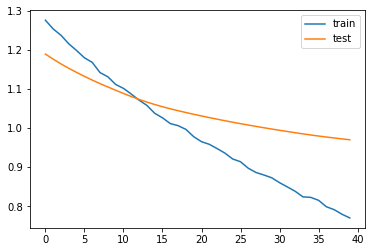

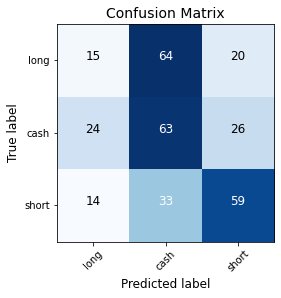

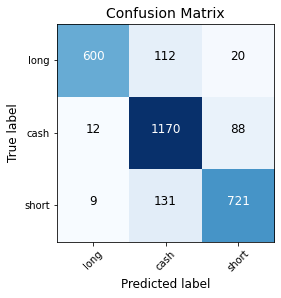

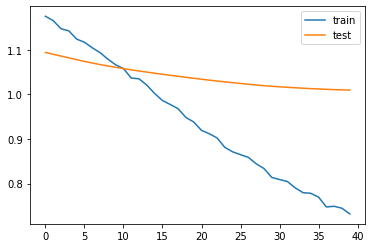

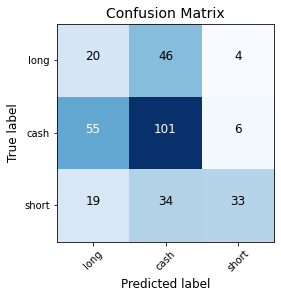

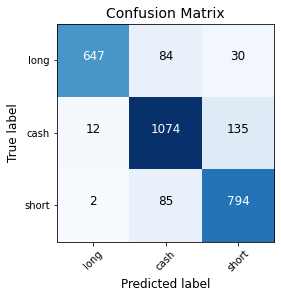

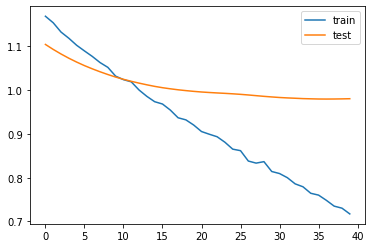

it took:  17 0.001 40 1024
long_f1: 0.16 std:  0.1 
 long_p: 0.24 std:  0.13 
 short_p: 0.58 std:  0.16 
 short_f1: 0.53 std:  0.13 

              precision    recall  f1-score   support

        long       0.98      0.85      0.91       761
        cash       0.86      0.88      0.87      1221
       short       0.83      0.90      0.86       881

    accuracy                           0.88      2863
   macro avg       0.89      0.88      0.88      2863
weighted avg       0.88      0.88      0.88      2863

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 40)                400       
_________________________________________________________________
dropout_19 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 3)                 123       


In [ ]:
kf = KFold(n_splits=10)
scaler = MinMaxScaler(feature_range=(0.00001, 1))
x = np.asarray(df) 
x = scaler.fit_transform(x)
y = np.asarray(label)
estimators, max_depth, min_sample_split, min_sample_leaf = 80, 20, 20, 5
max_depth, learning_rate, n_estimator, scale_pos_weight  = 6, 0.03, 100, 1

softmax_units = len(np.unique(labels))

units = [40]
epochs = [40]
batch_sizes = [1024]
lrs = [0.001]
fix_rnd_Keras() # fixing rnd of calculations

for lr in lrs:
    for unit in units:
        for batch_size in batch_sizes:
          for epoch in epochs:
            long_f1,short_p,short_f1,long_p= [],[],[],[]
            for train_index, test_index in kf.split(x):
              t = time.time()
              x_train, x_test = x[train_index], x[test_index]
              y_train, y_test = y[train_index], y[test_index]
              model_rf = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth,
                min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, 
                random_state = 13)
              model_rf.fit(x_train, y_train)  

              model_xgb =  XGBClassifier(max_depth=max_depth, learning_rate= learning_rate,
                                    n_estimators=n_estimator, scale_pos_weight = scale_pos_weight )
              model_xgb.fit(x_train, y_train)
             
              model_nn = Sequential()
              model_nn.add(Dense(units = 50,input_dim = x_train.shape[1], activation='relu'))
              model_nn.add(Dropout(0.5))
              
              model_nn.add(Dense(units = softmax_units,  activation='softmax'))
              opt = Adam(lr = 0.001)
              model_nn.compile(optimizer = opt, loss='sparse_categorical_crossentropy' ,  metrics=['accuracy'])
              history = model_nn.fit(x_train, y_train, epochs = 50, batch_size = 16,
            validation_data=(x_test, y_test),verbose = 0, shuffle=False, class_weight = {0:1.0,1:0.64, 2:0.89})

              
              pred = model_nn.predict(x_test) 
              preds_nn = []
              for i in range(len(pred)):
                  preds_nn.append(np.argmax(pred[i]))
              
              x_train= np.concatenate((model_nn.predict(x_train), model_rf.predict_proba(x_train),
                                       model_xgb.predict_proba(x_train)), axis=1)
              x_test= np.concatenate((model_nn.predict(x_test), model_rf.predict_proba(x_test),
                                      model_xgb.predict_proba(x_test)), axis=1)
              model = Sequential()
              model.add(Dense(units = unit,input_dim = x_train.shape[1], activation='relu'))
              model.add(Dropout(0.5))
              
              model.add(Dense(units = softmax_units,  activation='softmax'))
              opt = SGD(lr=lr, momentum=0.9, decay=0.001)
              opt = Adam(lr = lr)
              model.compile(optimizer = opt, loss='sparse_categorical_crossentropy' ,  metrics=['accuracy'])
              history = model.fit(x_train, y_train, epochs = epoch, batch_size = batch_size,
            validation_data=(x_test, y_test),verbose = 0, shuffle=False, class_weight = {0:1.3,1:1, 2:0.99})              
              pred = model.predict(x_test) 
              preds = []
              for i in range(len(pred)):
                  preds.append(np.argmax(pred[i]))
              pretty_print_conf_matrix(y_test,preds, 
                  classes= ['long', 'cash', 'short'],normalize=False, title='Confusion Matrix')
              pred_train = model.predict(x_train) 
              preds_train = []
              for i in range(len(pred_train)):
                  preds_train.append(np.argmax(pred_train[i]))
              pretty_print_conf_matrix(y_train,preds_train, 
                  classes= ['long', 'cash', 'short'],normalize=False, title='Confusion Matrix')
              rpt = classification_report(y_test, preds, target_names = ['long', 'cash', 'short'],output_dict=True)
              long_f1.append(rpt['long']['f1-score'])
              short_p.append(rpt['short']['precision'])   
              short_f1.append(rpt['short']['f1-score']) 
              long_p.append(rpt['long']['precision'])
              pyplot.plot(history.history['loss'], label='train')
              pyplot.plot(history.history['val_loss'], label='test')
              pyplot.legend()
              pyplot.show()
            print('it took: ', round(time.time()-t), lr,unit, batch_size)
            print('long_f1:', round(np.mean(long_f1),2), 'std: ', round(np.std(long_f1),2), '\n', 
                  'long_p:', round(np.mean(long_p),2), 'std: ', round(np.std(long_p),2), '\n',
                    'short_p:', round(np.mean(short_p),2), 'std: ', round(np.std(short_p), 2), '\n', 
                  'short_f1:', round(np.mean(short_f1),2), 'std: ', round(np.std(short_f1),2), '\n')
print(classification_report(y_train, preds_train, target_names = ['long', 'cash', 'short']))
model.summary()

## Save to drive

In [ ]:
pickle.dump(model_rf, open('model_rf.pkl','wb'))
pickle.dump(model_xgb, open('model_xgb.pkl','wb'))

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [ ]:
model_json = model_nn.to_json()
with open("model_nn.json", "w") as json_file:
    json_file.write(model_json)
model_nn.save_weights("model_nn.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp model.json "drive/My Drive/Data/money_again"
!cp model_nn.json "drive/My Drive/Data/money_again"
!cp model.h5 "drive/My Drive/Data/money_again"
!cp model_nn.h5 "drive/My Drive/Data/money_again"
!cp model_rf.pkl "drive/My Drive/Data/money_again"
!cp model_xgb.pkl "drive/My Drive/Data/money_again"

## Load

In [ ]:
json_file = open('drive/My Drive/Data/money_again/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("drive/My Drive/Data/money_again/model.h5")

json_file = open('drive/My Drive/Data/money_again/model_nn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_nn = model_from_json(loaded_model_json)
# load weights into new model
model_nn.load_weights("drive/My Drive/Data/money_again/model_nn.h5")

model_rf = pickle.load(open('drive/My Drive/Data/money_again/model_rf.pkl','rb'))
model_xgb = pickle.load(open('drive/My Drive/Data/money_again/model_xgb.pkl','rb'))

## Out of Sample test

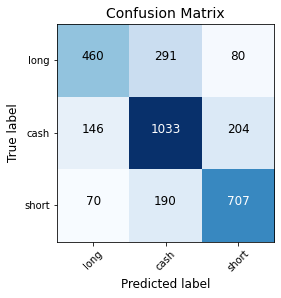

              precision    recall  f1-score   support

        long       0.68      0.55      0.61       831
        cash       0.68      0.75      0.71      1383
       short       0.71      0.73      0.72       967

    accuracy                           0.69      3181
   macro avg       0.69      0.68      0.68      3181
weighted avg       0.69      0.69      0.69      3181



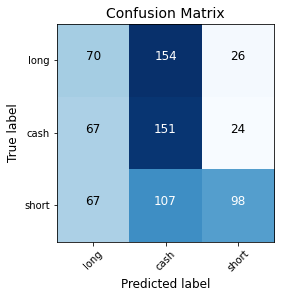

              precision    recall  f1-score   support

        long       0.34      0.28      0.31       250
        cash       0.37      0.62      0.46       242
       short       0.66      0.36      0.47       272

    accuracy                           0.42       764
   macro avg       0.46      0.42      0.41       764
weighted avg       0.46      0.42      0.41       764



In [ ]:
x = np.asarray(df) 
scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
x = scaler.fit_transform(x)
y = np.asarray(label)
x_train, y_train, x_test, y_test = x[:3181], y[:3181], x[3181:], y[3181:]
x_train= np.concatenate((model_nn.predict(x_train), model_rf.predict_proba(x_train),
                                       model_xgb.predict_proba(x_train)), axis=1)
x_test= np.concatenate((model_nn.predict(x_test), model_rf.predict_proba(x_test),
                        model_xgb.predict_proba(x_test)), axis=1)

pred_train = model.predict(x_train) 
preds_train = []
for i in range(len(pred_train)):
    preds_train.append(np.argmax(pred_train[i]))
pretty_print_conf_matrix(y_train,preds_train, 
    classes= ['long', 'cash', 'short'],normalize=False, title='Confusion Matrix')
rpt = classification_report(y_train, preds_train, target_names = ['long', 'cash', 'short'])
print(rpt)

pred_test = model.predict(x_test) 
preds_test = []
for i in range(len(pred_test)):
    preds_test.append(np.argmax(pred_test[i]))
pretty_print_conf_matrix(y_test,preds_test, 
    classes= ['long', 'cash', 'short'],normalize=False, title='Confusion Matrix')
rpt = classification_report(y_test, preds_test, target_names = ['long', 'cash', 'short'])
print(rpt)

# Others

## PCA

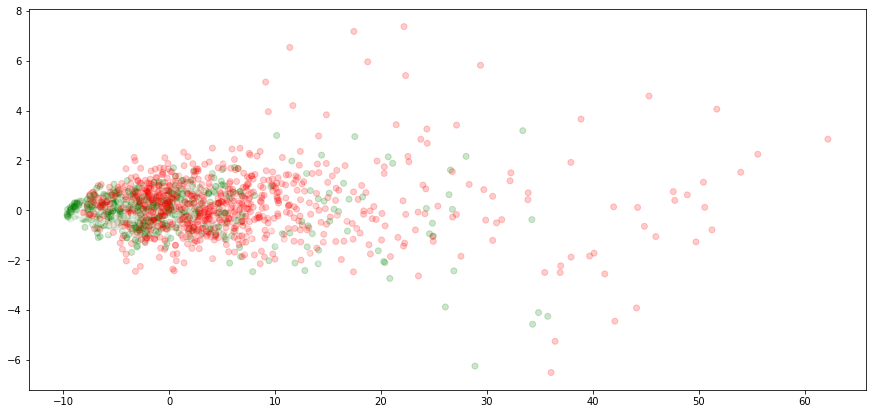

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.asarray(df))
pdf = pd.DataFrame(data = principalComponents
             , columns = ['one', 'two'])
a = pdf['one'].tolist()
b = pdf['two'].tolist()
plt.figure(figsize=(15,7))
plt.scatter(a,b, c = labels, alpha = 0.2);
#plt.axis([-10,20, -0.5,0.5]);

## TSNE

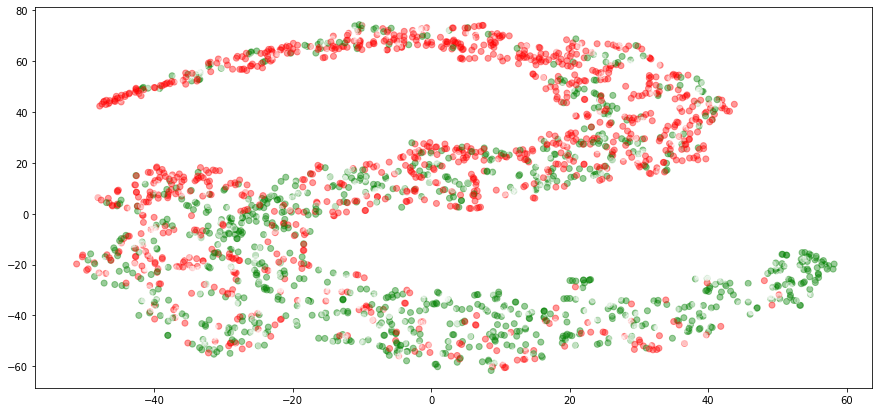

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=0)
tsne_results = tsne.fit_transform(np.asarray(df))
pdf = pd.DataFrame(data = tsne_results, columns = ['one', 'two'])
a = pdf['one'].tolist()
b = pdf['two'].tolist()
plt.figure(figsize=(15,7))
plt.scatter(a,b, c = labels, alpha = 0.4);

with features as 

cols = ['pct', 'vix', 'std_5', 'o_c', 'h_l', 'vol_sma_ema', 'vol_sma_ema_20', 'vol_spot_ema',
        'spot_sma_10', 'sma_10_20', 'sma_10_50',
       'spot_ema_10', 'ema_sma_10', 'ema_sma_20', 'vix_ema', 'vix_ema_sma_10', 'vix_ema_sma_20']

vix shows segregation in pca and tsne while spx does not much improve even for longer periods of time. Red is where it reduced and green increased significantly. White is buffer zone. 

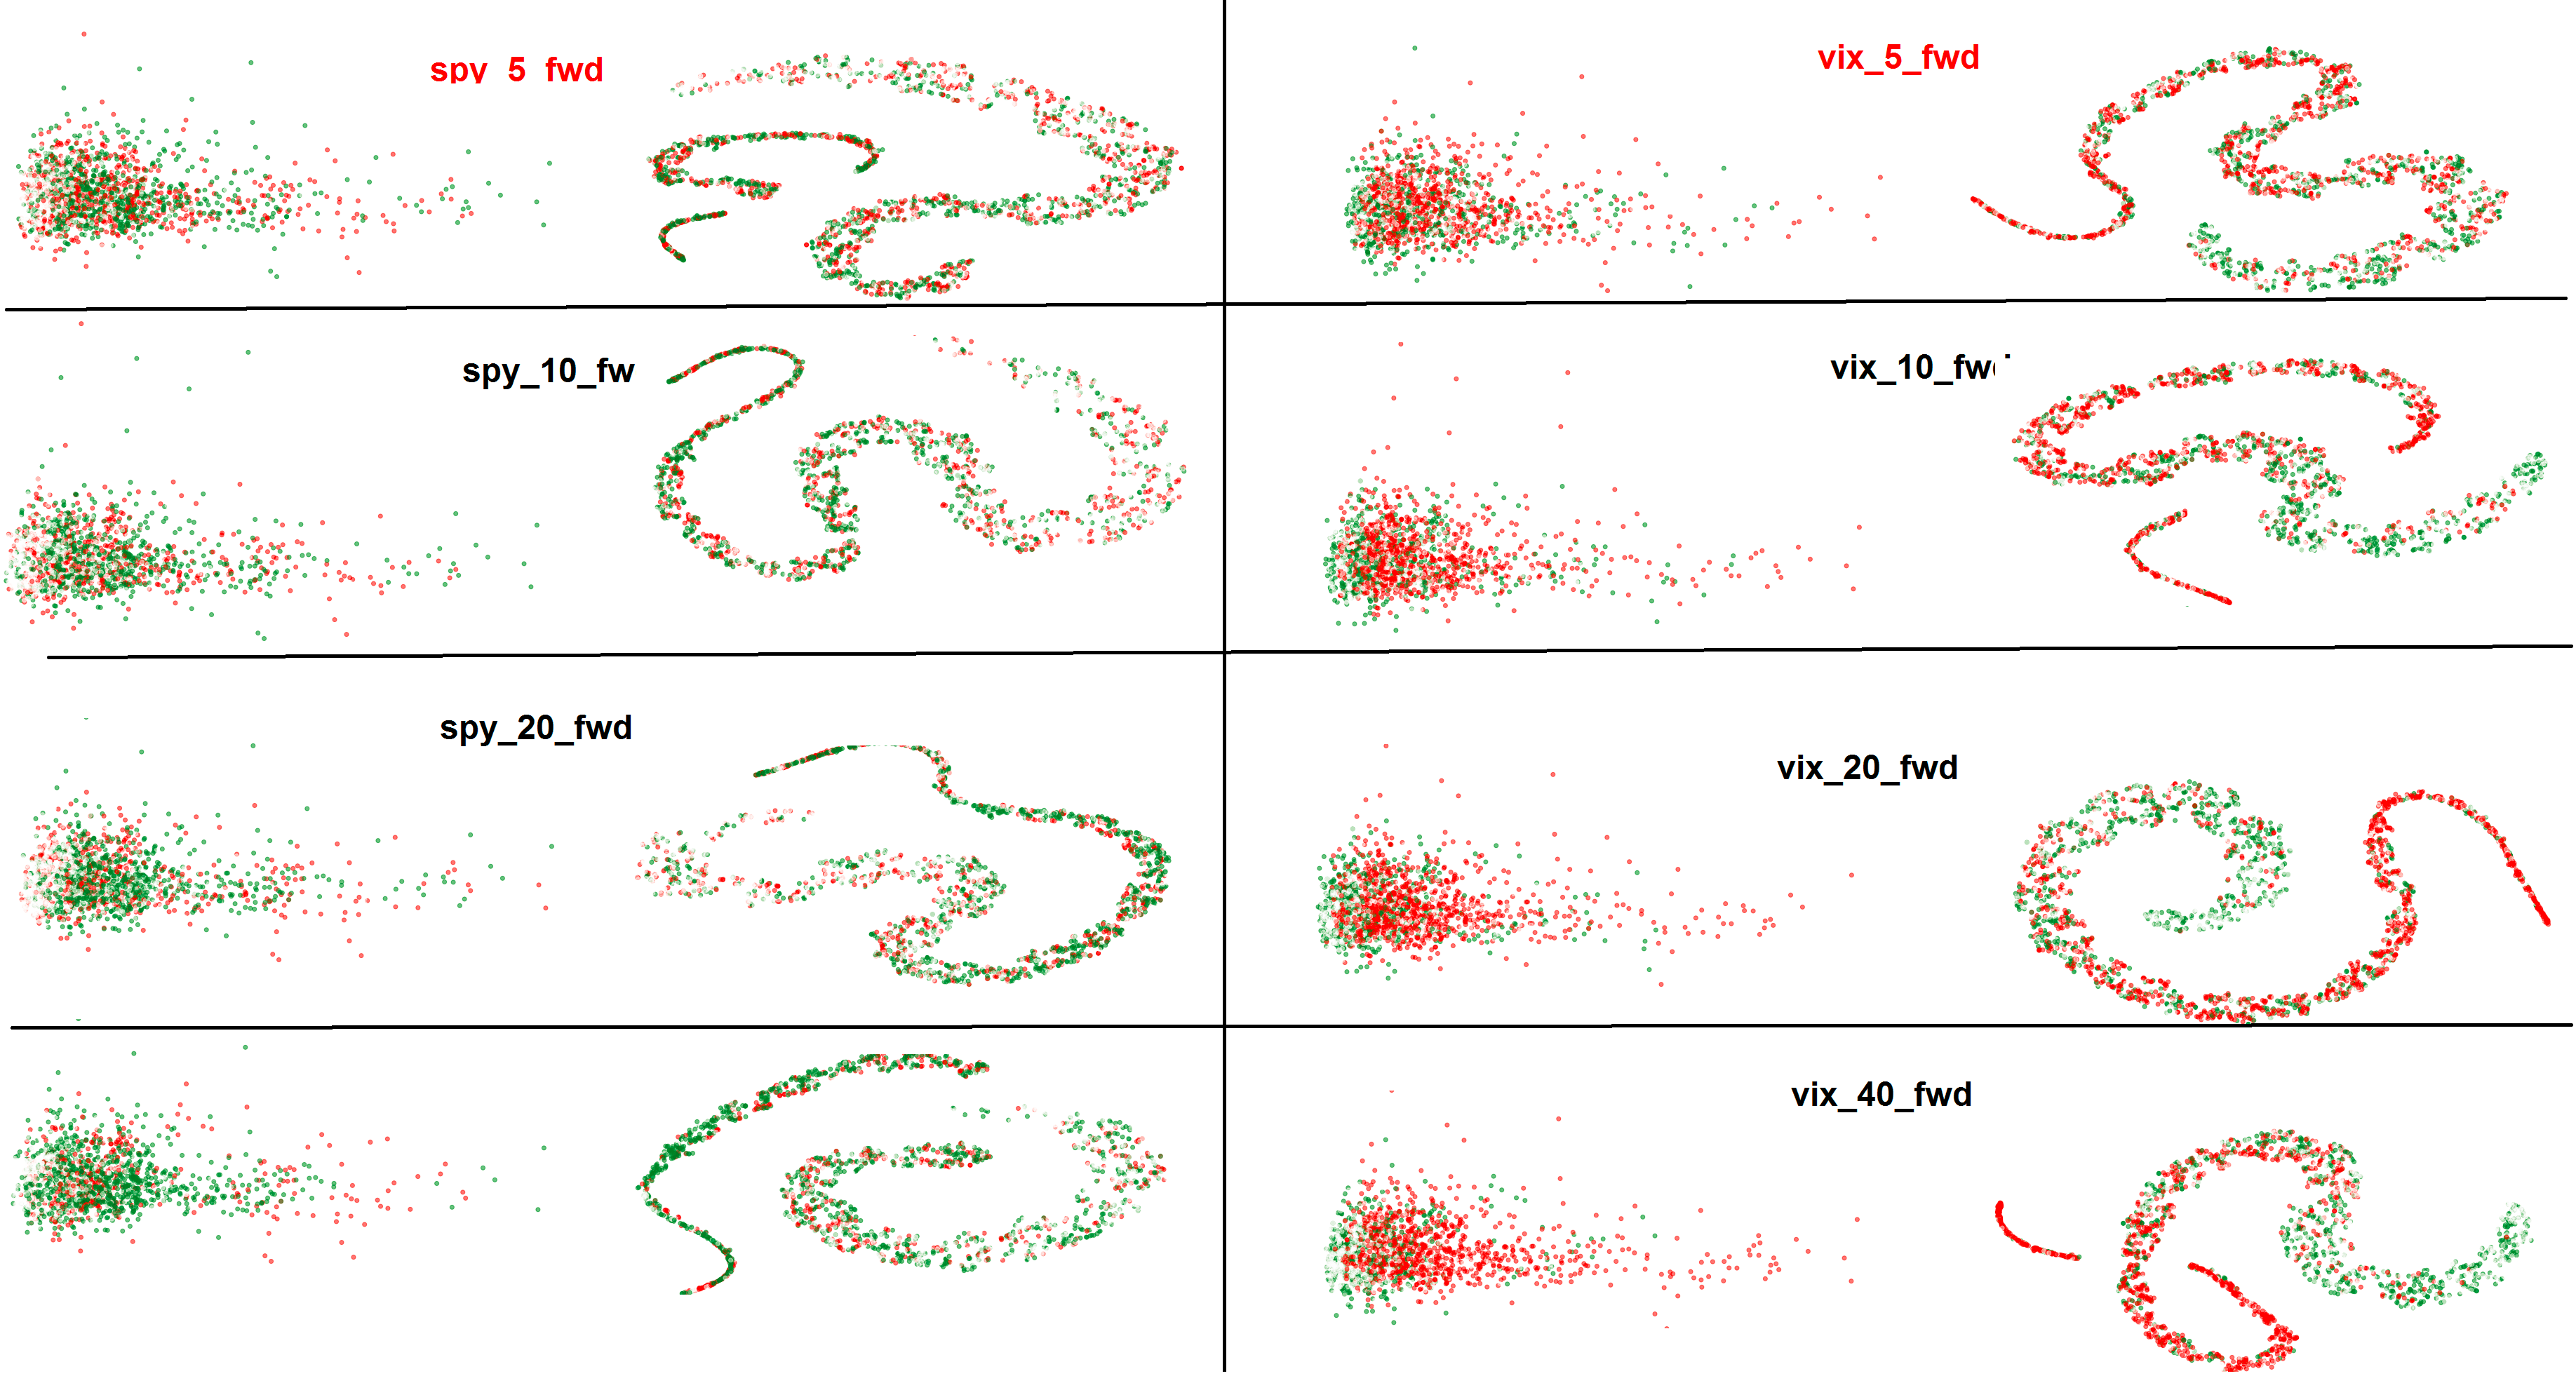

### More labels

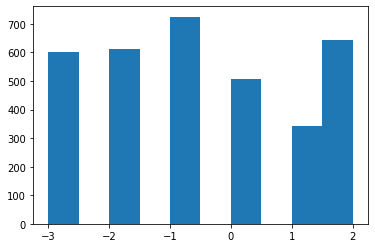

In [ ]:
df = spy[cols]
target = spy['fwd_20_vix']
labels = []
thresh = 0.08
for i in range(len(target)):
  if target[i] > 2*thresh:
    labels.append(2)
  elif target[i] > thresh and target[i]< 2*thresh:
    labels.append(1)
  elif target[i] > 0 and target[i]< thresh:
    labels.append(0)
  elif target[i] > -thresh and target[i]< 0:
    labels.append(-1)
  elif target[i] > -2*thresh and target[i]< -thresh:
    labels.append(-2)
  else:
    labels.append(-3)
plt.hist(labels);

### Use GPU

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


## Model

### LSTM

In [ ]:
x = np.asarray(df)
scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
x = scaler.fit_transform(x)
y = np.asarray(label)
x, y = windower(x,y,20,1)
y = OHE(y)
print(np.shape(x), np.shape(y))

(3311, 20, 13) (3311, 3)


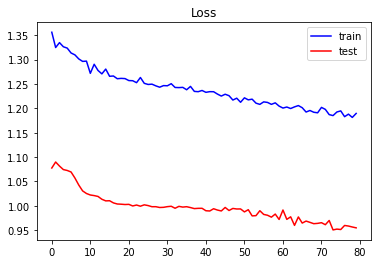

it took  37
              precision    recall  f1-score   support

           0       0.37      0.43      0.40       131
           1       0.63      0.54      0.58       242
           2       0.51      0.56      0.53       139

    accuracy                           0.52       512
   macro avg       0.50      0.51      0.50       512
weighted avg       0.53      0.52      0.52       512



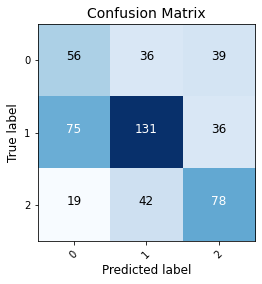

In [ ]:
t = time.time()
epochs = 80
train_ratio = 0.8
lr = 0.0009
batch_size = 128
x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)
fix_rnd_Keras() # fixing rnd of calculations
model = Sequential()
model.add(LSTM(units = 20, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2]),
               stateful=True))#, return_sequences = True))

model.add(Dropout(0.5))
model.add(Dense(units = 3, activation='softmax'))
opt = Adam(lr = lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
              epochs = epochs, batch_size = batch_size, verbose = 0, shuffle=False, class_weight = {0:1.2, 1:0.99, 2:1.6})
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train', color = 'blue')
pyplot.plot(history.history['val_loss'], label='test', color = 'red')
pyplot.legend()
pyplot.show()

prediction_test = model.predict(x_test, batch_size = batch_size)
prediction_train = model.predict(x_train, batch_size = batch_size)

print('it took ', round(time.time()-t))
# model.summary()
preds = []
Ys = []
for i in range(len(prediction_test)):
    preds.append(np.argmax(prediction_test[i]))
    Ys.append(np.argmax(y_test[i]))
pretty_print_conf_matrix(Ys,preds, classes= list(range(len(np.unique(labels)))),normalize=False, title='Confusion Matrix')
rpt = classification_report(Ys, preds, target_names = ['0', '1', '2'] )
print(rpt)

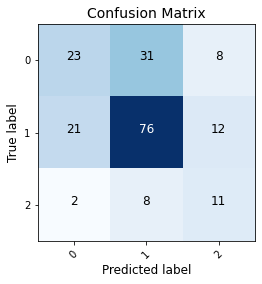

In [ ]:
preds = []
Ys = []
for i in range(len(prediction_test)):
    preds.append(np.argmax(prediction_test[i]))
    Ys.append(np.argmax(y_test[i]))
pretty_print_conf_matrix(Ys,preds, classes= list(range(len(np.unique(labels)))),normalize=False, title='Confusion Matrix')

## RF

(3331, 15) (3331,)
0.890015015015015 0.4332833583208396 30 45 10 5
random sampling gives accuracy of:  0.351
always selecting the max class:  0.405
              precision    recall  f1-score   support

           0       0.30      0.45      0.36       184
           1       0.43      0.34      0.38       270
           2       0.66      0.54      0.59       213

    accuracy                           0.43       667
   macro avg       0.46      0.44      0.44       667
weighted avg       0.47      0.43      0.44       667



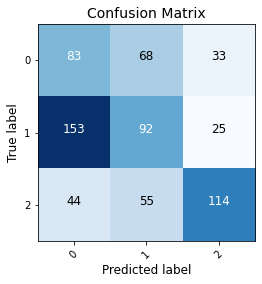

In [ ]:
x = np.asarray(df)
train_ratio = 0.8
len_train = int(len(x)*train_ratio)
scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
x = scaler.fit_transform(x)
y = np.asarray(label)
print(np.shape(x), np.shape(y))
x_train, y_train, x_test, y_test = x[:len_train], y[:len_train],x[len_train:], y[len_train:]
n_estimators, max_depths, min_samples_split, min_samples_leaf = [30], [45], [10], [5]

for estimators in n_estimators:   
    for max_depth in max_depths:
        for min_sample_split in min_samples_split:
            for min_sample_leaf in min_samples_leaf:
                model = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth,
                   min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, 
                   random_state = 13, class_weight = {0:1.4,1:0.6, 2:0.99})
                model.fit(x_train, y_train)  
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                print(accuracy_score(y_train, prediction_train),
        accuracy_score(y_test, prediction_test),estimators, max_depth, min_sample_split,min_sample_leaf)
                
print('random sampling gives accuracy of: ',round(accuracy_score(sample(list(y_test),(len(y_test))),y_test),3))
print('always selecting the max class: ',round(accuracy_score(len(y_test)*[1],y_test),3))
pretty_print_conf_matrix(y_test,prediction_test, classes= list(range(len(np.unique(labels)))),normalize=False, title='Confusion Matrix')
rpt = classification_report(y_test, prediction_test, target_names = ['0', '1', '2'] )
print(rpt)

[30], [45], [10], [5]
0.7 and o.52 for precision and f1 of class 2

class_weight = {0:1,1:0.8, 2:0.5}

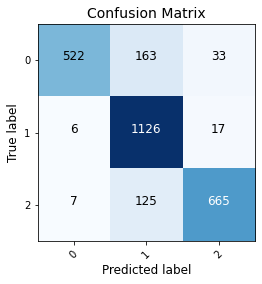

In [ ]:
pretty_print_conf_matrix(y_train,prediction_train, classes= list(range(len(np.unique(labels)))),normalize=False, title='Confusion Matrix')

In [ ]:
col_vix

['vix',
 'vix_ema',
 'vix_ema_sma_10',
 'vix_ema_sma_20',
 'vix_res10',
 'vix_res20',
 'vix_res50',
 'vix_sup10',
 'vix_sup20',
 'vix_sup50']

In [ ]:
feature_importances = pd.DataFrame({'importance':model.feature_importances_, 'feature' :cols})
feature_importances = feature_importances.round(3)
feature_importances.columns =['feature', 'importance']
feature_importances = feature_importances.sort_values('feature', ascending = False).reset_index(drop=True)
feature_importances

feature        importance
0     0.114               vix
1     0.055         vix_sup50
2     0.052         sma_10_50
3     0.050     gld_ema_10_50
4     0.042             std_5
5     0.042         vix_sup20
6     0.041     tlt_ema_10_50
7     0.040         vix_res50
8     0.031        ema_sma_20
9     0.030               h_l
10    0.028      vix_slope_20
11    0.028   tlt_vol_sma_ema
12    0.028   gld_spot_ema_10
13    0.028   gld_vol_sma_ema
14    0.026         sma_10_20
15    0.026    vix_ema_sma_20
16    0.025       spot_ema_10
17    0.024       spot_sma_10
18    0.024    vol_sma_ema_20
19    0.023         vix_res20
20    0.022         vix_sup10
21    0.022   tlt_spot_ema_10
22    0.021        ema_sma_10
23    0.020       vol_sma_ema
24    0.020      vix_slope_10
25    0.020       vix_slope_5
26    0.018         vix_res10
27    0.017           vix_ema
28    0.015      vol_spot_ema
29    0.015    vix_ema_sma_10
30    0.014  tlt_vol_spot_ema
31    0.014  gld_vol_spot_ema
32    0.014               o_c
33    0.011               pct

### SHAP

In [ ]:
explainerRF = shap.TreeExplainer(model, x_train)

Passing 2664 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


In [ ]:
shap_values = explainerRF.shap_values(x_train[:5])


 93%|=================== | 14/15 [00:18<00:01]       

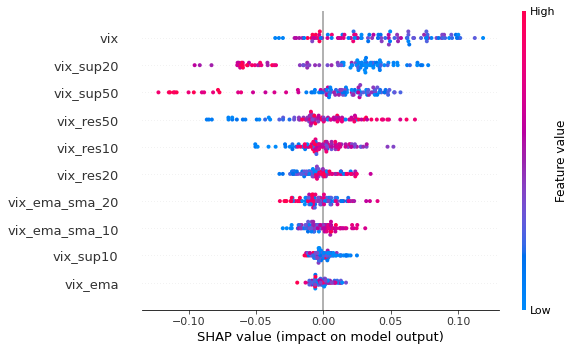

In [ ]:
shap.summary_plot(shap_values[0], x_train[:100], feature_names=col_vix) # volitility increases

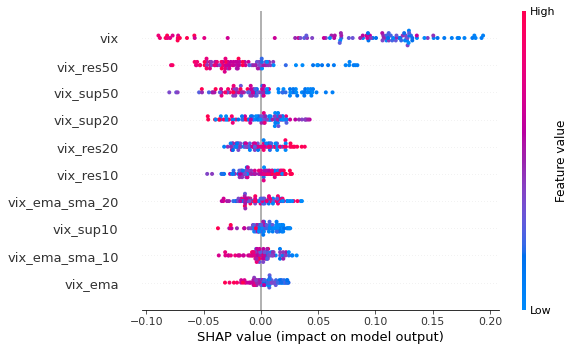

In [ ]:
shap.summary_plot(shap_values[1], x_train[:100], feature_names=col_vix)

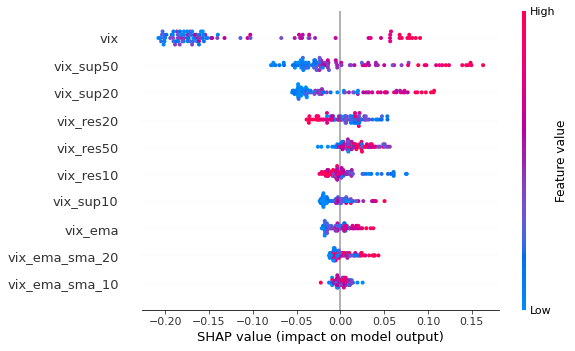

In [ ]:
shap.summary_plot(shap_values[2], x_train[:100], feature_names=col_vix) # class for vol decreases. 

In [ ]:
shap.summary_plot(shap_values, x_train, feature_names=col_vix)

## Linear reg

(3331, 10) (3331,)
0.07069405518536842
train:  -12.15
test:  -15.75


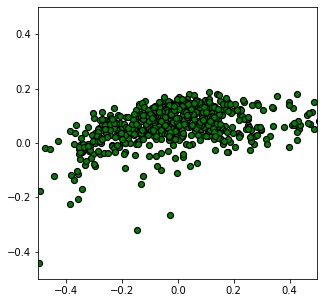

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

x = np.asarray(df)
train_ratio = 0.8
len_train = int(len(x)*train_ratio)
scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
x = scaler.fit_transform(x)
y = np.asarray(target)
print(np.shape(x), np.shape(y))
x_train, y_train, x_test, y_test = x[:len_train], y[:len_train],x[len_train:], y[len_train:]
model = LinearRegression()
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
model.score(x_test, y_test)
prediction_test = model.predict(x_test)
prediction_train = model.predict(x_train)
print('train: ', round(r2_score(prediction_train, y_train), 2))
print('test: ', round(r2_score(prediction_test, y_test), 2))
plt.figure(figsize=(5,5))
plt.scatter(y_test, prediction_test, marker = 'o',edgecolor='black', linewidth=1.2, color = 'green');
plt.axis([-0.5,0.5, -0.5,0.5]);

## NN

(3331, 15) (3331,)


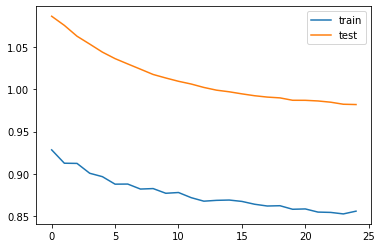

it took:  3
0.001 200 128 Accuracy: 40.18%
              precision    recall  f1-score   support

           0       0.31      0.65      0.42       184
           1       0.24      0.06      0.10       270
           2       0.63      0.62      0.63       213

    accuracy                           0.40       667
   macro avg       0.39      0.44      0.38       667
weighted avg       0.38      0.40      0.35       667

random sampling gives accuracy of:  0.337
always selecting the max class:  0.405


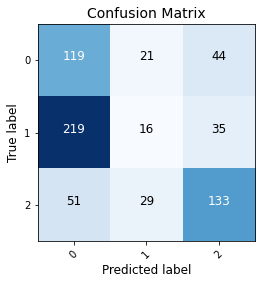

In [ ]:
t = time.time()
x = np.asarray(df)
train_ratio = 0.8
len_train = int(len(x)*train_ratio)
scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
x = scaler.fit_transform(x)
y = np.asarray(label)
print(np.shape(x), np.shape(y))
x_train, y_train, x_test, y_test = x[:len_train], y[:len_train],x[len_train:], y[len_train:]

softmax_units = len(np.unique(labels))
#for loops were used to get to these optimal values for units, lr, epochs, etc:
units = [ 200]
epochs = 25
batch_sizes = [ 128]
lrs = [0.001]
fix_rnd_Keras() # fixing rnd of calculations

for lr in lrs:
    for unit in units:
        for batch_size in batch_sizes:
            model_nn = Sequential()
            model_nn.add(Dense(units = unit,input_dim = x_train.shape[1], activation='relu'))
            model_nn.add(Dropout(0.5))
            
            model_nn.add(Dense(units = softmax_units,  activation='softmax'))
            opt = SGD(lr=lr, momentum=0.9, decay=0.001)
            opt = Adam(lr = lr)
            model_nn.compile(optimizer = opt, loss='sparse_categorical_crossentropy' ,  metrics=['accuracy'])
            history = model_nn.fit(x_train, y_train, epochs = epochs, batch_size = batch_size,validation_data=(x_test, y_test),
                  verbose = 0, shuffle=False, class_weight = {0:1.0,1:0.64, 2:0.99})
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='test')
            pyplot.legend()
            pyplot.show()
            scores = model_nn.evaluate(x_test, y_test, verbose=0)
            print('it took: ', round(time.time()-t))
            print(lr,unit, batch_size, "Accuracy: %.2f%%" % (scores[1]*100))
            pred = model_nn.predict(x_test) 
            preds = []
            for i in range(len(pred)):
                preds.append(np.argmax(pred[i]))
            pretty_print_conf_matrix(y_test,preds, classes= list(range(len(np.unique(labels)))),normalize=False, title='Confusion Matrix')

            rpt = classification_report(y_test, preds, target_names = ['0', '1', '2'] )
            print(rpt)
print('random sampling gives accuracy of: ',round(accuracy_score(sample(list(y_test),(len(y_test))),y_test),3))
print('always selecting the max class: ',round(accuracy_score(len(y_test)*[1],y_test),3))



vix features:
0.01 200 256
precision of 0.7 and f1 of 0.6 for class 2.

{0:1.4,1:0.99, 2:0.9}

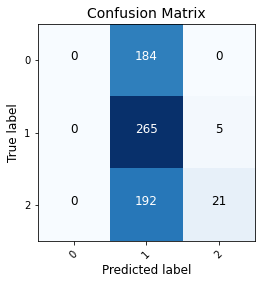

In [ ]:
pred = model_nn.predict(x_test) 
preds = []
for i in range(len(pred)):
    preds.append(np.argmax(pred[i]))
pretty_print_conf_matrix(y_test,preds, classes= list(range(len(np.unique(labels)))),normalize=False, title='Confusion Matrix')

In [ ]:
rpt = classification_report(y_test, preds, target_names = ['0', '1', '2'] )
print(rpt)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       184
           1       0.41      0.98      0.58       270
           2       0.81      0.10      0.18       213

    accuracy                           0.43       667
   macro avg       0.41      0.36      0.25       667
weighted avg       0.43      0.43      0.29       667



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
explainerRF = shap.TreeExplainer(model, x_train)
shap_values = explainerRF.shap_values(x_train)
shap.summary_plot(shap_values[0], x_train[:100], plot_type='bar', color='brown')

Passing 2664 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
  2%|                   | 161/7992 [03:24<165:22]       

## reTest Past work

In [ ]:
def difference_pct_back(datafile, lag = 1):
    diff = [0] * lag
    for i in range(lag,len(datafile)):
        diff.append(datafile[i]/datafile[i-lag]-1)
    return diff

def EMA(df, EMA_days):
    sma = np.mean(df[0:EMA_days])
    EMA_list = [0] * (EMA_days - 1)
    EMA_list.append(sma)
    c = 2/(1+EMA_days)
    for i in range(EMA_days,len(df)):
        a = EMA_list[i-1]*(1-c)+ c*df[i]
        EMA_list.append(a)
    return(EMA_list)

def SMA(df, sma_days):
    sma_list = [0] * (sma_days - 1)
    for i in range(sma_days, len(df)+1):
        sma_list.append(np.mean(df[i-sma_days:i]))
    return(sma_list)

def y_classifier(array, threshold):
    classes = []
    for i in range(len(array)):
        if array[i,0] > threshold:
            classes.append(1)
        elif array[i,0] < -1*threshold:
            classes.append(-1)
        else:
            classes.append(0)
    return np.asarray(classes)

def create_dataset_percentage_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1)) 
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]/dataset[i+window_size-1,0]-1
        data_Y.append(b)
        i += gap
        
    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

#split x and y to test and train that are devisible to batch_size
def test_train_split(x, y, batch_size, train_ratio):       
    train_length = int(len(x)*train_ratio)
    for i in range(train_length, train_length+batch_size):
        remainder = i%batch_size
        if remainder == 0:
            train_length = i
            break
    x_train = x[:train_length,:]
    y_train = y[:train_length]

    for i in range(len(x)-batch_size, len(x)):
        remainder = i%batch_size
        if remainder == 0:
            train_length_test = i
            break
    x_test = x[train_length:train_length_test,:]
    y_test = y[train_length:train_length_test]
    return x_train, y_train, x_test, y_test

In [ ]:
DF = pdr.get_data_yahoo('SPY', start = '2000-01-01', end = '2017-10-1')

df = DF.Close
df = df.dropna(axis=0, how='any')

#making moving averages
v_10 = SMA(DF.Volume, 10)
v_20 = SMA(DF.Volume, 20)
open_close = (DF.Close/DF.Open - 1).tolist()
high_low = (DF.High/DF.Low - 1).tolist()
EMA_8 = EMA(df,8)
SMA_10 = SMA(df,10)
SMA_20 = SMA(df,20)
SMA_50 = SMA(df,50)
SMA_100 = SMA(df,100)
pct_day = difference_pct_back(df, 1)
list_df = df.tolist()
vol_list = DF.Volume.tolist()
MAs = pd.DataFrame(list(zip(list_df, pct_day, vol_list, v_10, v_20,open_close,high_low, EMA_8, SMA_10, 
                            SMA_20, SMA_50, SMA_100)),columns=['spot', 'pct_day', 'vol', 'v_10', 'v_20',
                            'open_close', 'high_low', 'EMA_8', 'SMA_10', 'SMA_20', 'SMA_50','SMA_100'])

#removing all rows with 0 in them
MAs = MAs[100:]
MAs = MAs.reset_index(drop=True)

#making differences as features
MAs['v10'] = MAs.vol/MAs.v_10 - 1
MAs['v20'] = MAs.vol/MAs.v_20 - 1
MAs['spot_EMA'] = MAs.spot/MAs.EMA_8 - 1
MAs['spot_20SMA'] = MAs.spot/MAs.SMA_20 - 1
MAs['spot_50SMA'] = MAs.spot/MAs.SMA_50 - 1
MAs['spot_100SMA'] = MAs.spot/MAs.SMA_100 - 1
MAs['10_100_SMA'] = MAs.SMA_10/MAs.SMA_100 - 1
MAs['20_50_SMA'] = MAs.SMA_20/MAs.SMA_50 - 1
MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)

In [ ]:
train_ratio = 0.8
batch_size = 8
look_forward = 20
n_estimators, max_depths, min_samples_split, min_samples_leaf = [12], [40], [10], [4]
n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl, long_fscores = [], [], [], [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr =  [], [], [], [], []

for estimators in n_estimators:   
    for max_depth in max_depths:
        for min_sample_split in min_samples_split:
            for min_sample_leaf in min_samples_leaf:
                scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, 1, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, 1, look_forward,1)
                y = y_classifier(y, 0.02)
                x = x.reshape(len(x), -1)
                
                x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)
                model = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth,
                   min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, random_state = 413)
                model.fit(x_train, y_train)  
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                print(accuracy_score(y_train, prediction_train),
        accuracy_score(y_test, prediction_test),estimators, max_depth, min_sample_split,min_sample_leaf)

0.9135057471264367 0.5911214953271028 12 40 10 4


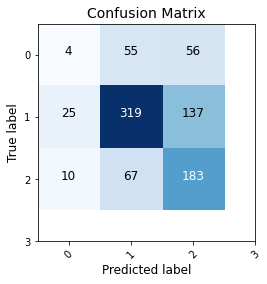

In [ ]:
pretty_print_conf_matrix(y_test,prediction_test, classes= list(range(4)),normalize=False, title='Confusion Matrix')

- random sampling as benchmark.

- Shap.



